# AI Project(Team 22)

## Necessary Imports

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from pandas.api.types import is_string_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import math as math

## Preprocessing

In [92]:
df=pd.read_csv('train.csv')

C:\Users\Vivek\AppData\Local\Temp\ipykernel_27604\3155070436.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('train.csv')


In [93]:
df.isnull().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64

### Visualisation of Class Distribution

C:\Users\Vivek\AppData\Local\Temp\ipykernel_26996\1887653274.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')
C:\Users\Vivek\AppData\Local\Temp\ipykernel_26996\1887653274.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=class_col, order=class_names, palette=palette_map)


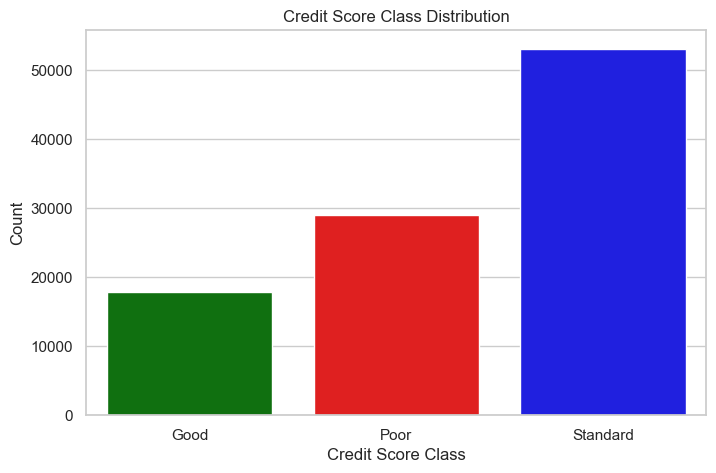

In [60]:

df = pd.read_csv('train.csv')

class_col = 'Credit_Score'
class_names = ['Good', 'Poor', 'Standard'] 
palette_map = {'Good': 'green', 'Poor': 'red', 'Standard': 'blue'}

# 1. Bar plot for class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=class_col, order=class_names, palette=palette_map)
plt.title('Credit Score Class Distribution')
plt.xlabel('Credit Score Class')
plt.ylabel('Count')
plt.show()

### Replacing Null and Invalid Values

In [94]:
df.shape

(100000, 28)

In [95]:
df = df.replace(['', 'NULL','NA', None], np.nan)

In [96]:
threshold=df.shape[1]/2
df=df.dropna(thresh=threshold)

In [97]:
df.shape

(100000, 28)

In [98]:
valid_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
df['Month'] = df['Month'].where(df['Month'].isin(valid_months), np.nan)

In [99]:
df['Month'].isnull().sum()

np.int64(0)

In [100]:
df['Occupation']=df['Occupation'].replace('_',np.nan)

### Forward Fill and Backward Fill to imputer missing values and Conversion to Numeric data

In [101]:
def ffill_bfill(df, columns):
    for column in columns:
        df[column] = df.groupby('Customer_ID')[column].ffill().bfill()
    return df

In [102]:
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    return df

In [103]:
columns=['Name','Age','Occupation']
df=ffill_bfill(df,columns)

In [104]:
columns=['Age','Annual_Income','Num_Credit_Card','Num_of_Loan','Interest_Rate','Num_of_Delayed_Payment','Changed_Credit_Limit','Delay_from_due_date','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance','Total_EMI_per_month','Credit_Utilization_Ratio','Num_Credit_Inquiries','Num_Bank_Accounts','Monthly_Inhand_Salary']
df=convert_to_numeric(df, columns)

In [105]:
df['SSN'] = df['SSN'].where(df['SSN'].str.match(r'^\d'), np.nan)

In [106]:
df['Occupation'] = df['Occupation'].where(df['Occupation'].str.contains(r'[a-zA-Z]'), np.nan)

In [107]:
columns=['SSN','Occupation']
df=ffill_bfill(df,columns)

In [108]:
def most_frequent(series):
    mode = series.mode()
    if not mode.empty:
        return mode[0]
    else:
        return np.nan

def fill_with_mode_or_ffill_bfill(df, cols):
    group_col = 'Customer_ID' 

    for col in cols:
        most_common = df.groupby(group_col)[col].transform(most_frequent)
        df[col] = df[col].fillna(most_common)
        
        # Then ffill and bfill within each group
        df[col] = df.groupby(group_col)[col].transform(lambda x: x.ffill().bfill())

    return df

In [109]:
columns=['Annual_Income','Monthly_Inhand_Salary','Num_of_Loan','Type_of_Loan']
df=ffill_bfill(df,columns)

In [110]:
def most_frequent(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan

In [111]:
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(
    lambda x: x.fillna(most_frequent(x))
)

In [112]:
df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(
    lambda x: x.fillna(most_frequent(x))
)

In [113]:
df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(
    lambda x: x.fillna(most_frequent(x))
)

In [114]:
df['Credit_Mix'] = df['Credit_Mix'].replace('_', np.nan)

In [115]:
def fill_credit_mix(group):
    mode_value = group.mode()
    if not mode_value.empty:
        return group.fillna(mode_value[0]) 
    else:
        return group  # Return unchanged if mode not found

df['Credit_Mix'] = df.groupby('Name')['Credit_Mix'].transform(fill_credit_mix)

# Step 2: If entire group was NaN, use ffill & bfill from other groups
df['Credit_Mix'] = df['Credit_Mix'].ffill().bfill()

In [116]:
columns=['Outstanding_Debt','Amount_invested_monthly','Monthly_Balance']
df=ffill_bfill(df,columns)

In [117]:
df['Credit_History_Age'] = df['Credit_History_Age'].astype(str)


In [118]:
df['Credit_History_Age'].head(30)          

0      22 Years and 1 Months
1                        nan
2      22 Years and 3 Months
3      22 Years and 4 Months
4      22 Years and 5 Months
5      22 Years and 6 Months
6      22 Years and 7 Months
7                        nan
8      26 Years and 7 Months
9      26 Years and 8 Months
10     26 Years and 9 Months
11    26 Years and 10 Months
12    26 Years and 11 Months
13     27 Years and 0 Months
14     27 Years and 1 Months
15     27 Years and 2 Months
16     17 Years and 9 Months
17    17 Years and 10 Months
18    17 Years and 11 Months
19                       nan
20     18 Years and 1 Months
21     18 Years and 2 Months
22     18 Years and 3 Months
23     18 Years and 4 Months
24     17 Years and 3 Months
25     17 Years and 4 Months
26     17 Years and 5 Months
27     17 Years and 6 Months
28     17 Years and 7 Months
29     17 Years and 8 Months
Name: Credit_History_Age, dtype: object

In [119]:
def parse_credit_age(age_str):
    if age_str == 'nan' or pd.isna(age_str):
        return np.nan
    parts = age_str.split()
    years = int(parts[0]) if 'Year' in parts[1] else 0
    months = int(parts[3]) if 'Month' in parts[4] else 0
    return years * 12 + months

def format_credit_age(months):
    if pd.isna(months):
        return 'nan'
    years = int(months) // 12
    rem_months = int(months) % 12
    return f"{years} Years and {rem_months} Months"

def fill_credit_history(group):
    # Convert strings to numeric months
    months = group.apply(parse_credit_age)

    # Forward fill logic
    for i in range(1, len(months)):
        if pd.isna(months.iloc[i]):
            prev_idx = i - 1
            while prev_idx >= 0 and pd.isna(months.iloc[prev_idx]):
                prev_idx -= 1
            if prev_idx >= 0:
                months.iloc[i] = months.iloc[prev_idx] + 1

    # Backward fill logic
    for i in range(len(months) - 2, -1, -1):
        if pd.isna(months.iloc[i]):
            months.iloc[i] = months.iloc[i + 1] - 1

    # Convert back to original string format
    return months.apply(format_credit_age)

df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(fill_credit_history)


In [120]:
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                         4939
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Payment_Behaviour              0
Monthly_Balance                0
Credit_Score                   0
dtype: int64

In [121]:
df['Payment_of_Min_Amount'] = df.groupby('Name')['Payment_of_Min_Amount'].transform(fill_credit_mix)

df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].ffill().bfill()

In [122]:
df['Payment_Behaviour'] = df['Payment_Behaviour'].transform(
    lambda value: value if isinstance(value, str) and value.startswith(('H', 'L')) else np.nan
)


In [123]:
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                         4939
SSN                            0
Occupation                     0
Annual_Income                  0
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit           0
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly        0
Payment_Behaviour           7600
Monthly_Balance                0
Credit_Score                   0
dtype: int64

In [124]:
df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].transform(fill_credit_mix)

# Step 2: If entire group was NaN, use ffill & bfill from other groups
df['Payment_Behaviour'] = df['Payment_Behaviour'].ffill().bfill()

In [125]:
df['Type_of_Loan']=df['Type_of_Loan'].replace("",np.nan)

In [126]:
df['Age']=pd.to_numeric(df['Age'],errors='coerce')

In [127]:
df['Age'].isnull().sum()

np.int64(4939)

In [128]:
numeric_columns=['Age','Annual_Income','Num_Credit_Card','Num_of_Loan','Interest_Rate','Num_of_Delayed_Payment','Changed_Credit_Limit','Delay_from_due_date','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance','Num_of_Loan','Total_EMI_per_month','Credit_Utilization_Ratio','Num_Credit_Inquiries','Num_Bank_Accounts','Monthly_Inhand_Salary']

### Boxplots for all columns

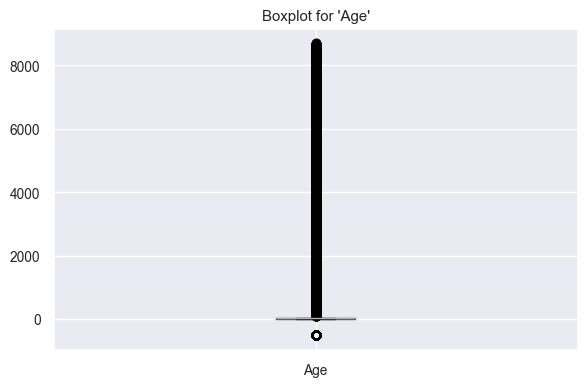

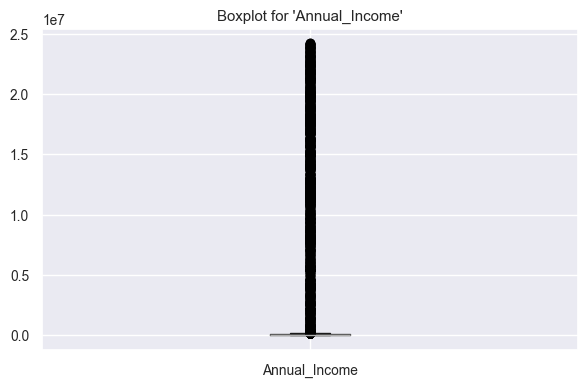

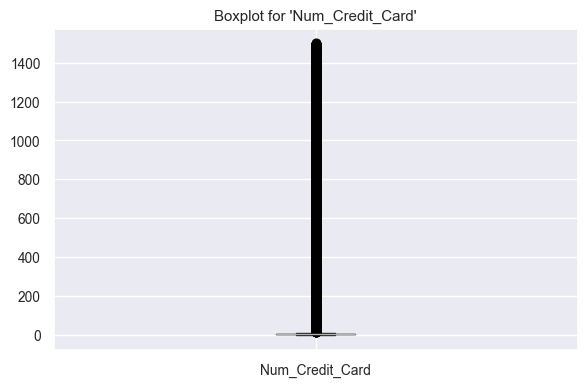

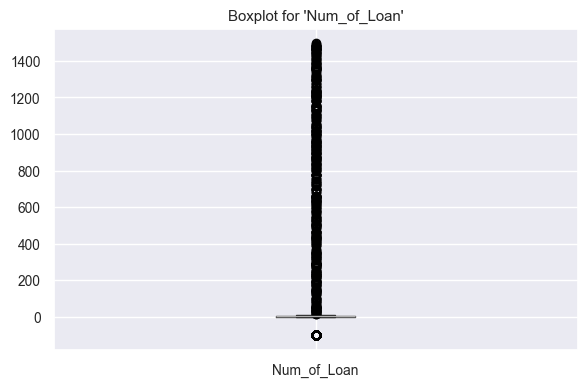

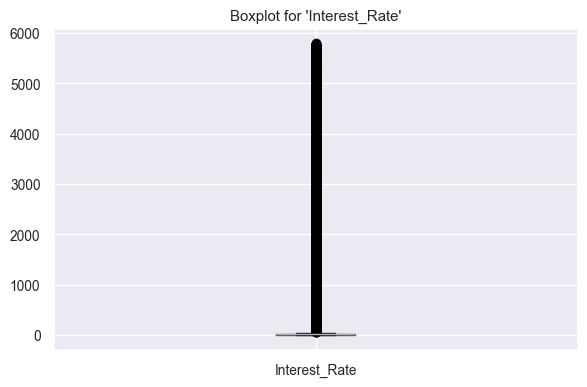

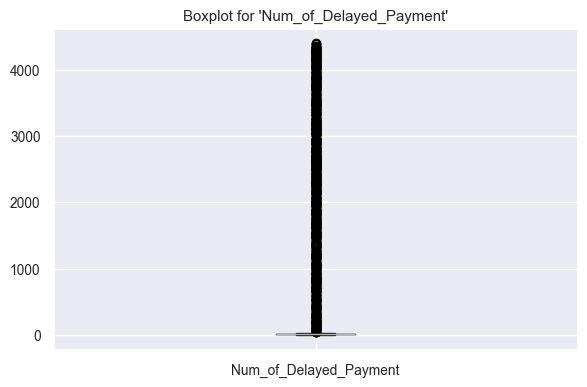

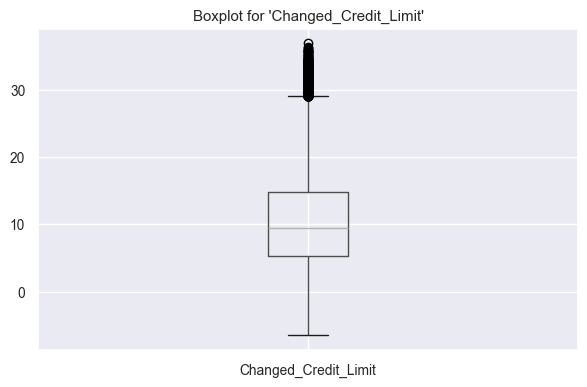

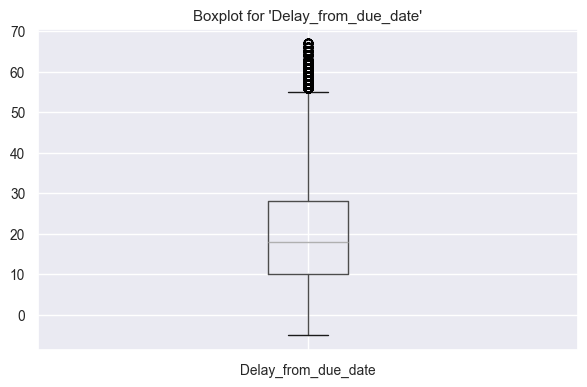

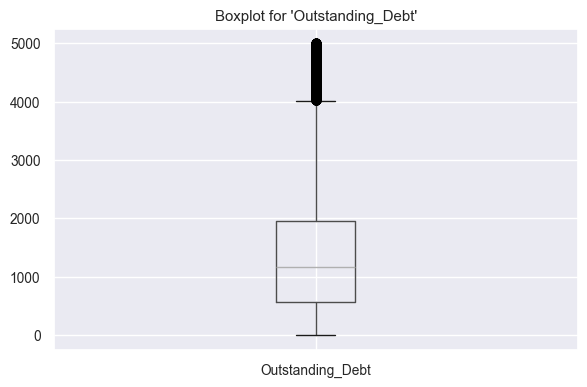

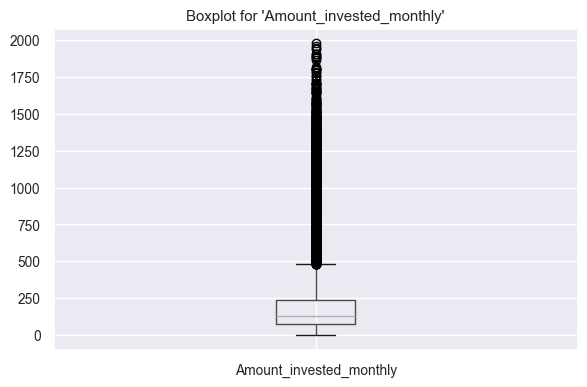

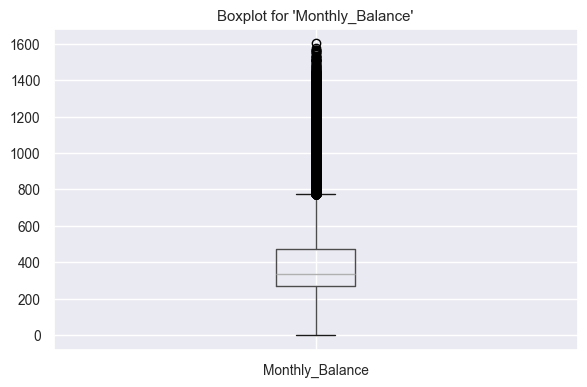

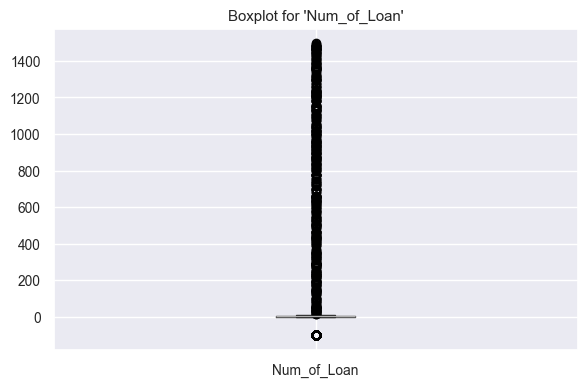

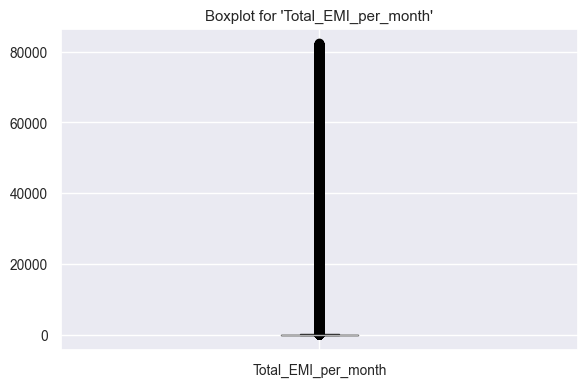

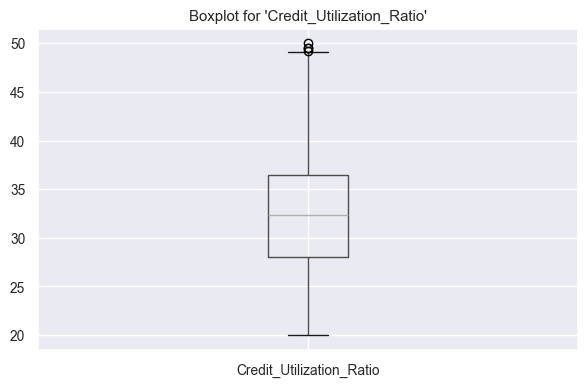

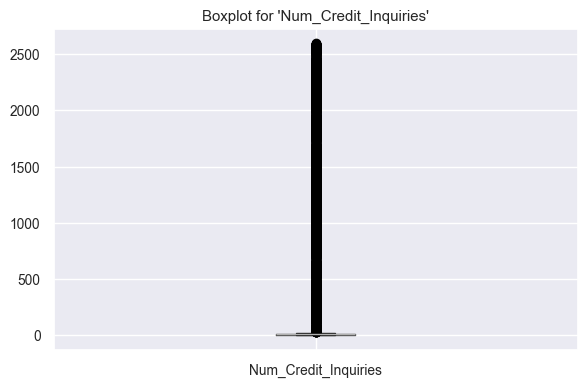

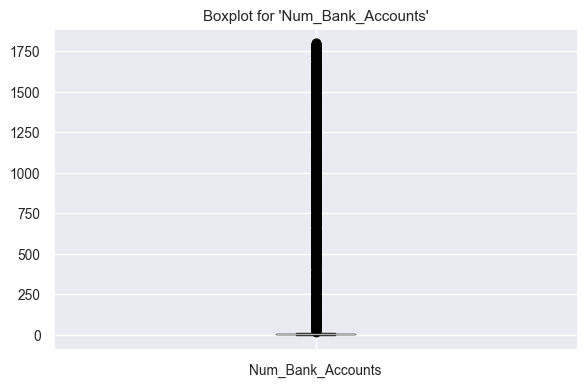

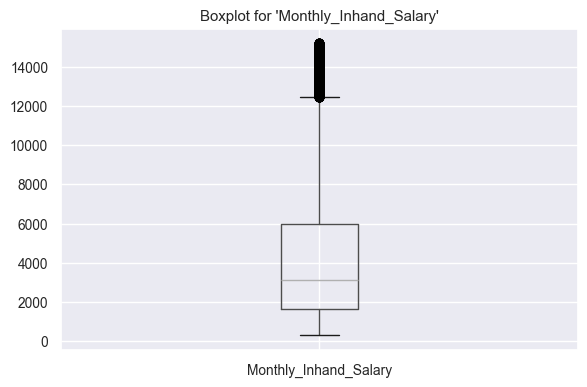

In [129]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    df.boxplot(column=col)
    plt.title(f"Boxplot for '{col}'")
    plt.tight_layout()
    plt.show()

### Removing outliers

In [130]:
def remove_outliers_iqr(df, columns):
    
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan

    return df


In [131]:
target_columns=['Age','Annual_Income','Num_Credit_Card','Num_of_Loan','Interest_Rate','Num_of_Delayed_Payment','Changed_Credit_Limit','Delay_from_due_date','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance','Num_of_Loan','Total_EMI_per_month','Credit_Utilization_Ratio','Num_Credit_Inquiries','Num_Bank_Accounts','Monthly_Inhand_Salary']

In [132]:
df=remove_outliers_iqr(df, target_columns)

In [133]:
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                         7635
SSN                            0
Occupation                     0
Annual_Income               2795
Monthly_Inhand_Salary       2009
Num_Bank_Accounts           1315
Num_Credit_Card             2271
Interest_Rate               2034
Num_of_Loan                 4545
Type_of_Loan                   0
Delay_from_due_date         4002
Num_of_Delayed_Payment       717
Changed_Credit_Limit         723
Num_Credit_Inquiries        1650
Credit_Mix                     0
Outstanding_Debt            5272
Credit_Utilization_Ratio       4
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month         6795
Amount_invested_monthly     8329
Payment_Behaviour              0
Monthly_Balance             7684
Credit_Score                   0
dtype: int64

In [134]:
def filling(df,col):
    df[col]=df.groupby('Customer_ID')[col].ffill().bfill()

In [135]:
df['Age'].head(20)

0     23.0
1     23.0
2      NaN
3     23.0
4     23.0
5     23.0
6     23.0
7     23.0
8      NaN
9     28.0
10    28.0
11    28.0
12    28.0
13    28.0
14    28.0
15    28.0
16    34.0
17    34.0
18    34.0
19    34.0
Name: Age, dtype: float64

In [136]:
df['Age']=df.groupby('Customer_ID')['Age'].ffill().bfill()

In [137]:
df['Num_Bank_Accounts']=df.groupby('Customer_ID')['Num_Bank_Accounts'].ffill().bfill()

In [138]:
filling(df,'Num_Credit_Card')

In [139]:
filling(df,'Interest_Rate')

In [140]:
filling(df,'Num_of_Loan')

In [141]:
def most_frequent(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan  # Return NaN if mode is empty

df['Delay_from_due_date'] = df.groupby('Customer_ID')['Delay_from_due_date'].transform(
    lambda x: x.fillna(most_frequent(x))
)


In [142]:
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                            0
SSN                            0
Occupation                     0
Annual_Income               2795
Monthly_Inhand_Salary       2009
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date         2656
Num_of_Delayed_Payment       717
Changed_Credit_Limit         723
Num_Credit_Inquiries        1650
Credit_Mix                     0
Outstanding_Debt            5272
Credit_Utilization_Ratio       4
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month         6795
Amount_invested_monthly     8329
Payment_Behaviour              0
Monthly_Balance             7684
Credit_Score                   0
dtype: int64

In [143]:
filling(df,'Delay_from_due_date')

In [144]:

df['Credit_Mix'] = df['Credit_Mix'].replace(['-', 'NaN', 'nan'], np.nan)

In [145]:
cols=['Annual_Income','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries']

In [146]:
df=fill_with_mode_or_ffill_bfill(df, cols)

In [147]:
filling(df,'Monthly_Inhand_Salary')
filling(df,'Outstanding_Debt')
filling(df,'Credit_Utilization_Ratio')
filling(df,'Total_EMI_per_month')

In [148]:
df.isnull().sum()

ID                             0
Customer_ID                    0
Month                          0
Name                           0
Age                            0
SSN                            0
Occupation                     0
Annual_Income               1792
Monthly_Inhand_Salary          0
Num_Bank_Accounts              0
Num_Credit_Card                0
Interest_Rate                  0
Num_of_Loan                    0
Type_of_Loan                   0
Delay_from_due_date            0
Num_of_Delayed_Payment         0
Changed_Credit_Limit         240
Num_Credit_Inquiries           0
Credit_Mix                     0
Outstanding_Debt               0
Credit_Utilization_Ratio       0
Credit_History_Age             0
Payment_of_Min_Amount          0
Total_EMI_per_month            0
Amount_invested_monthly     8329
Payment_Behaviour              0
Monthly_Balance             7684
Credit_Score                   0
dtype: int64

In [149]:
filling(df,'Credit_Utilization_Ratio')

In [150]:
def most_frequent(hh_series):
    mode = hh_series.mode()
    if not mode.empty:
        return mode.iloc[0]
    else:
        return np.nan

In [151]:
df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(most_frequent)


In [152]:
filling(df,'Annual_Income')
filling(df,'Changed_Credit_Limit')

In [153]:
columns=['Amount_invested_monthly','Monthly_Balance']
df=ffill_bfill(df,columns)

In [154]:
df.columns = df.columns.str.strip()


In [155]:
def normalize_columns(df, columns):
    for column in columns:
        min_val = df[column].min()
        max_val = df[column].max()
        df[column] = (df[column] - min_val) / (max_val - min_val)
    
    return df


In [156]:
target_columns=['Annual_Income','Num_Credit_Card','Num_of_Loan','Interest_Rate','Num_of_Delayed_Payment','Changed_Credit_Limit','Delay_from_due_date','Outstanding_Debt','Amount_invested_monthly','Monthly_Balance','Num_of_Loan','Total_EMI_per_month','Credit_Utilization_Ratio','Num_Credit_Inquiries','Num_Bank_Accounts','Monthly_Inhand_Salary']

### Normalising Attributes

In [157]:
df=normalize_columns(df,target_columns)

In [158]:
df.isnull().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

### New boxplots after processing the data

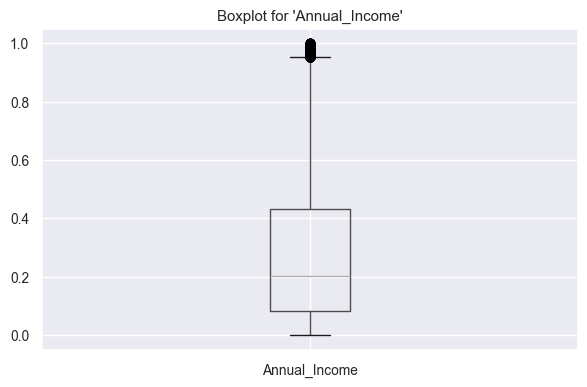

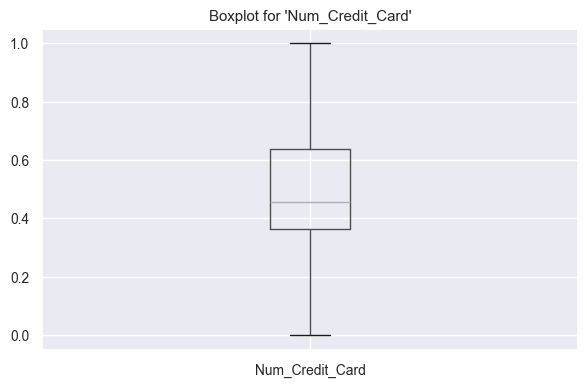

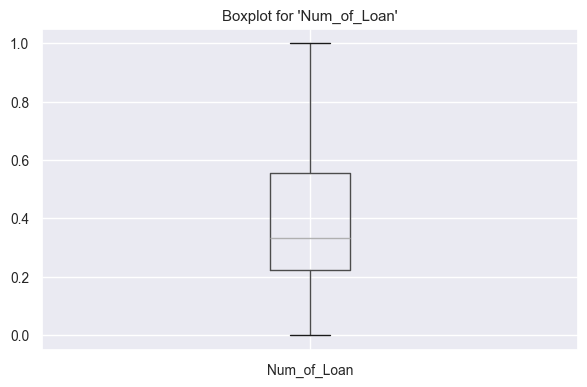

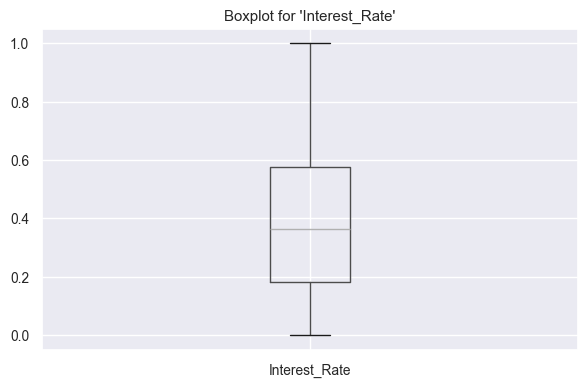

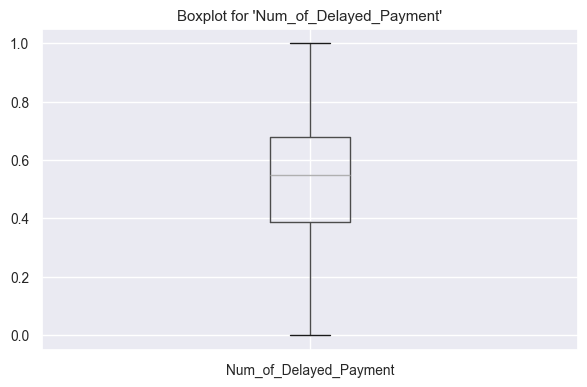

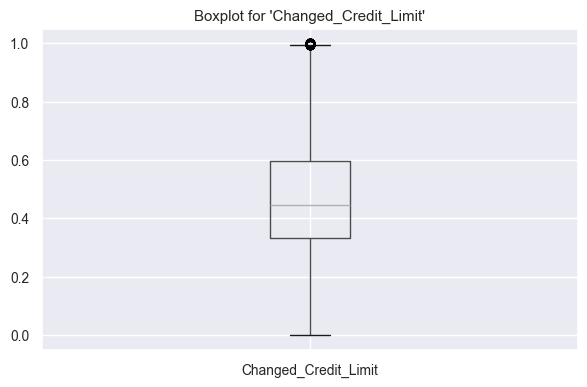

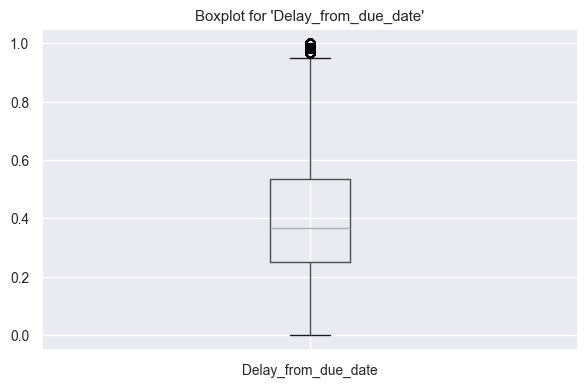

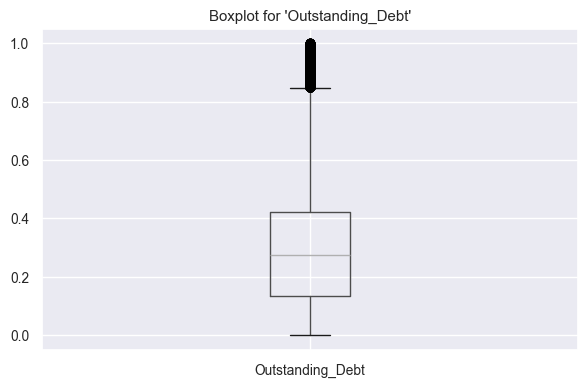

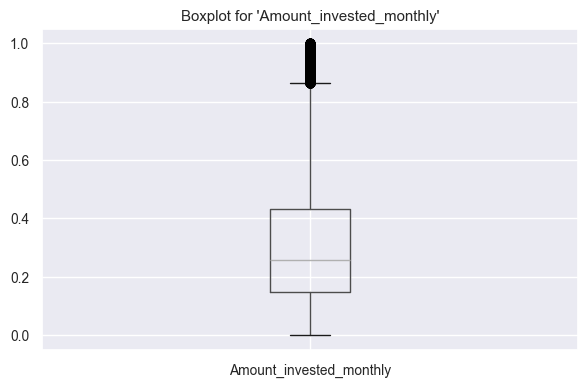

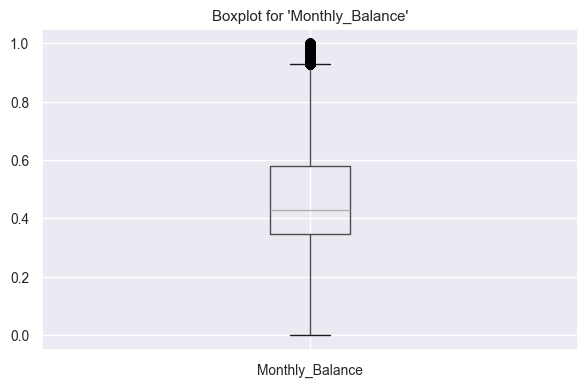

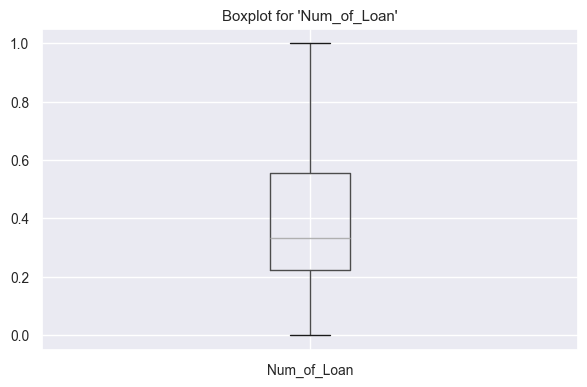

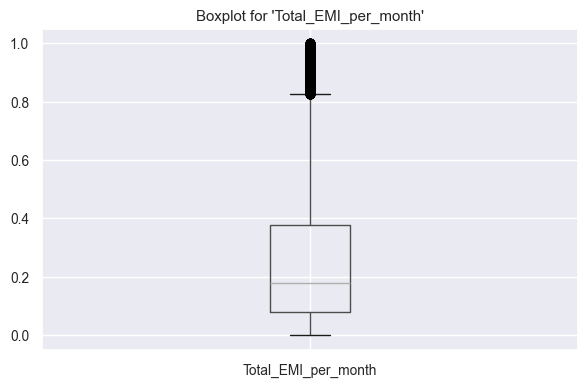

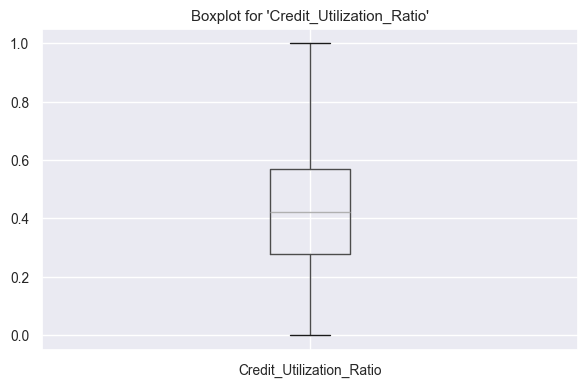

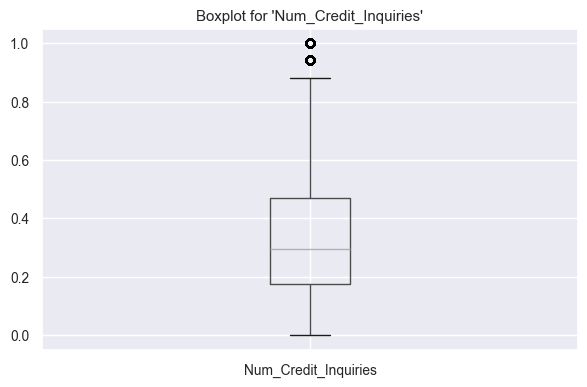

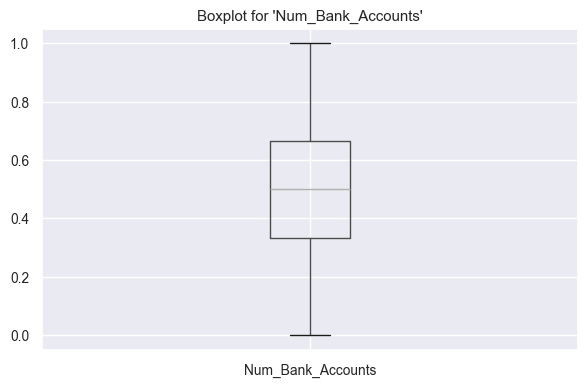

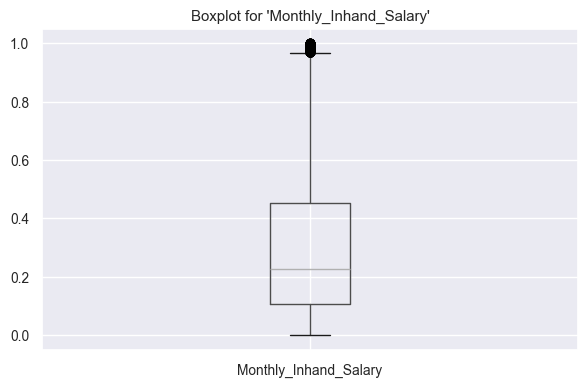

In [159]:
for col in target_columns:
    plt.figure(figsize=(6, 4))
    df.boxplot(column=col)
    plt.title(f"Boxplot for '{col}'")
    plt.tight_layout()
    plt.show()

### Dropping irrelevent columns by Domain Knowledge

In [160]:
df = df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Month'], axis=1, errors='ignore')

### Encoding String data as numeric

In [161]:
def convert_credit_history_age(age_str):
    try:
        years, months = map(int, [age_str.split(' Years ')[0], age_str.split(' and ')[-1].split(' Months')[0]])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_history_age)

In [162]:
label_encoder = LabelEncoder()
df['Credit_Score'] = label_encoder.fit_transform(df['Credit_Score'])

categorical_cols = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

### Heatmap analysis of data

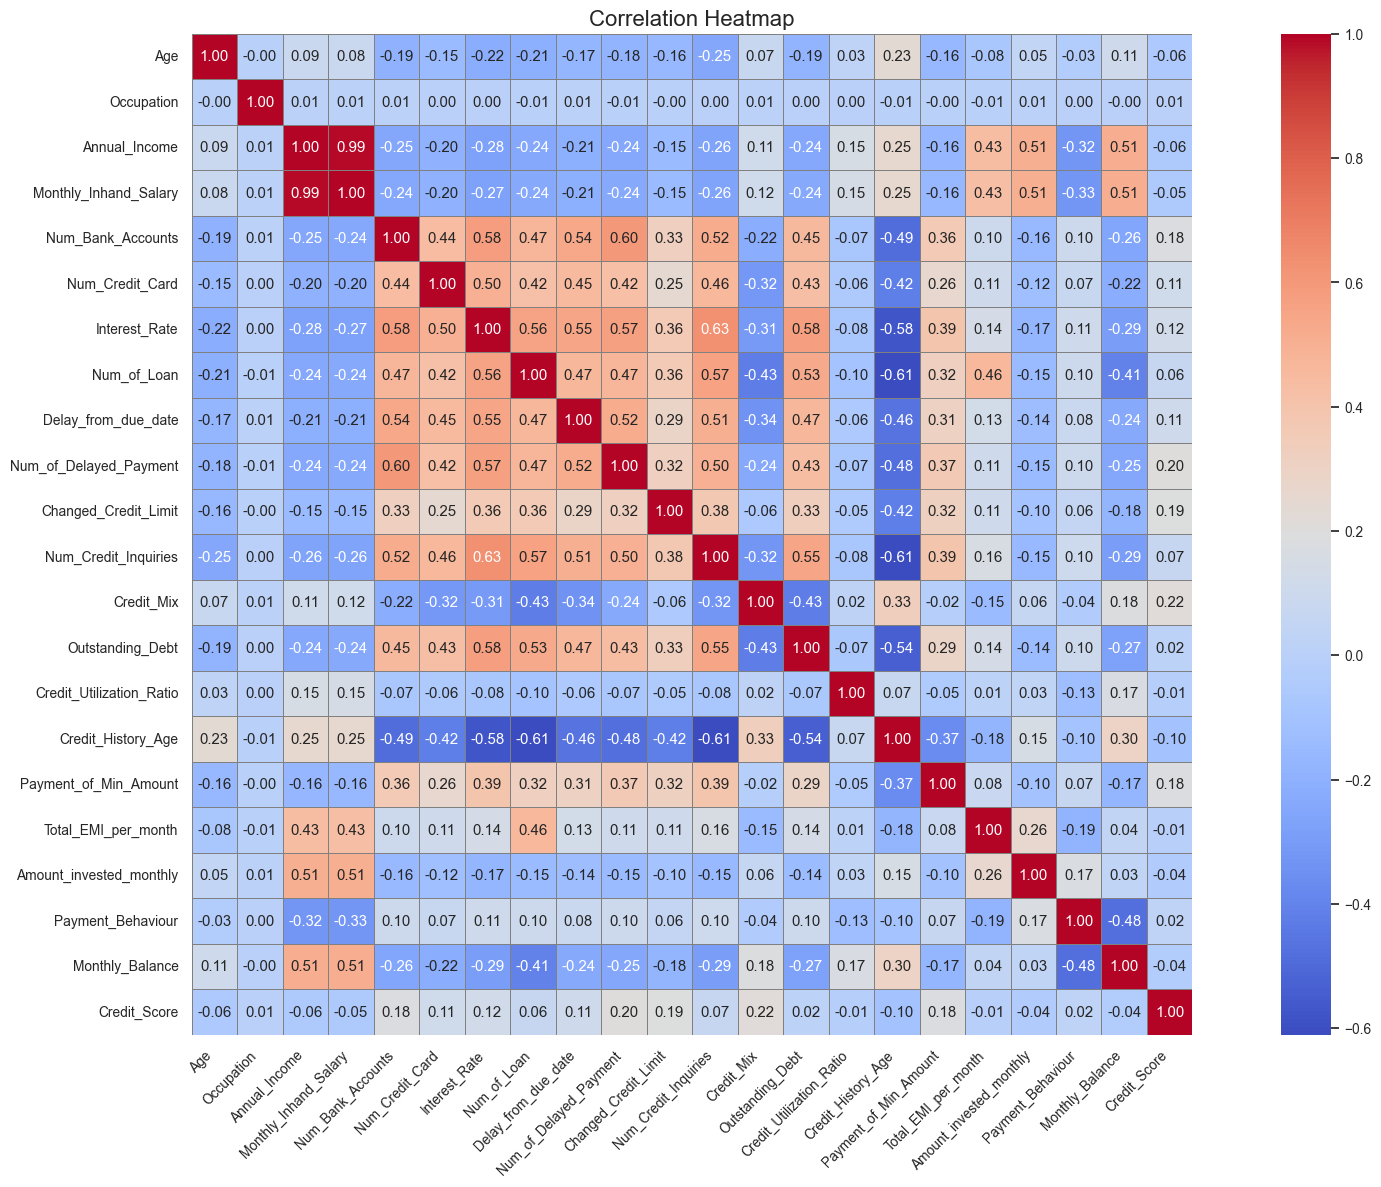

In [163]:
plt.figure(figsize=(18, 12))  # Make the heatmap larger
sns.set(font_scale=0.9)  # Adjust font scale for readability

corr = df.corr()

# Plot heatmap
ax = sns.heatmap(
    corr,
    annot=True,           # show values
    fmt=".2f",            # format to 2 decimal places
    cmap="coolwarm",      # better color map
    cbar=True,
    linewidths=0.5,       # add grid lines between cells
    linecolor='gray',     # grid line color
    square=True           # keep it square shaped
)

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x labels for clarity
plt.yticks(rotation=0)               # Keep y labels horizontal
plt.tight_layout()
plt.show()

### Histogram distribution of all relevent attributes

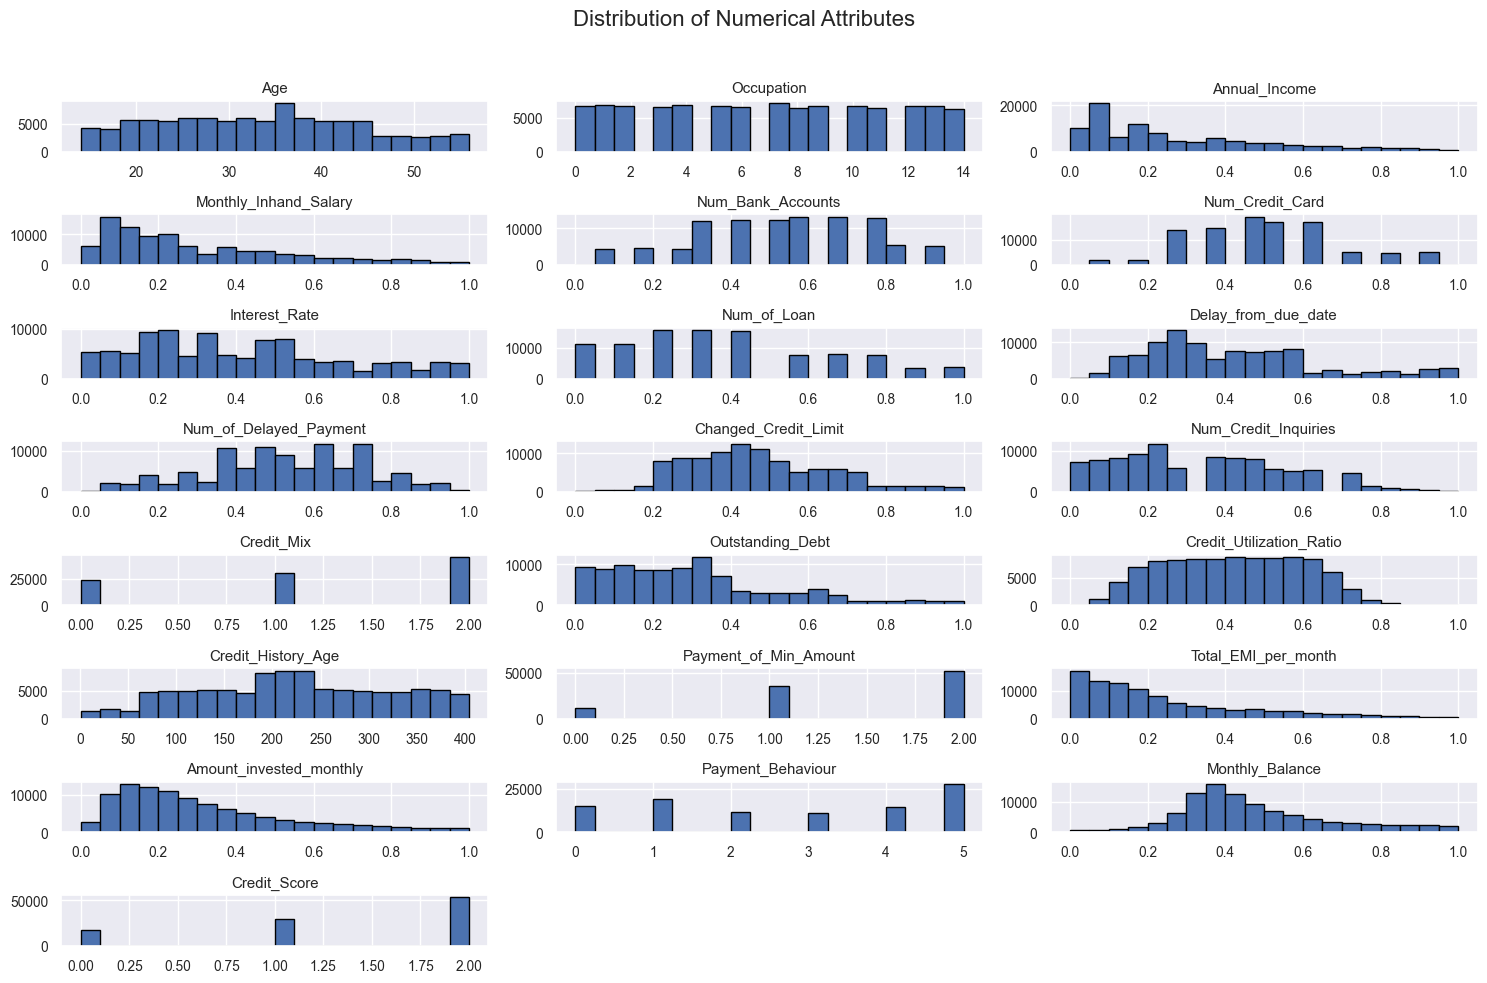

In [164]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram for each numerical column
df[numeric_columns].hist(bins=20, figsize=(15, 10), edgecolor='black', layout=(len(numeric_columns)//3 + 1, 3))
plt.suptitle('Distribution of Numerical Attributes', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


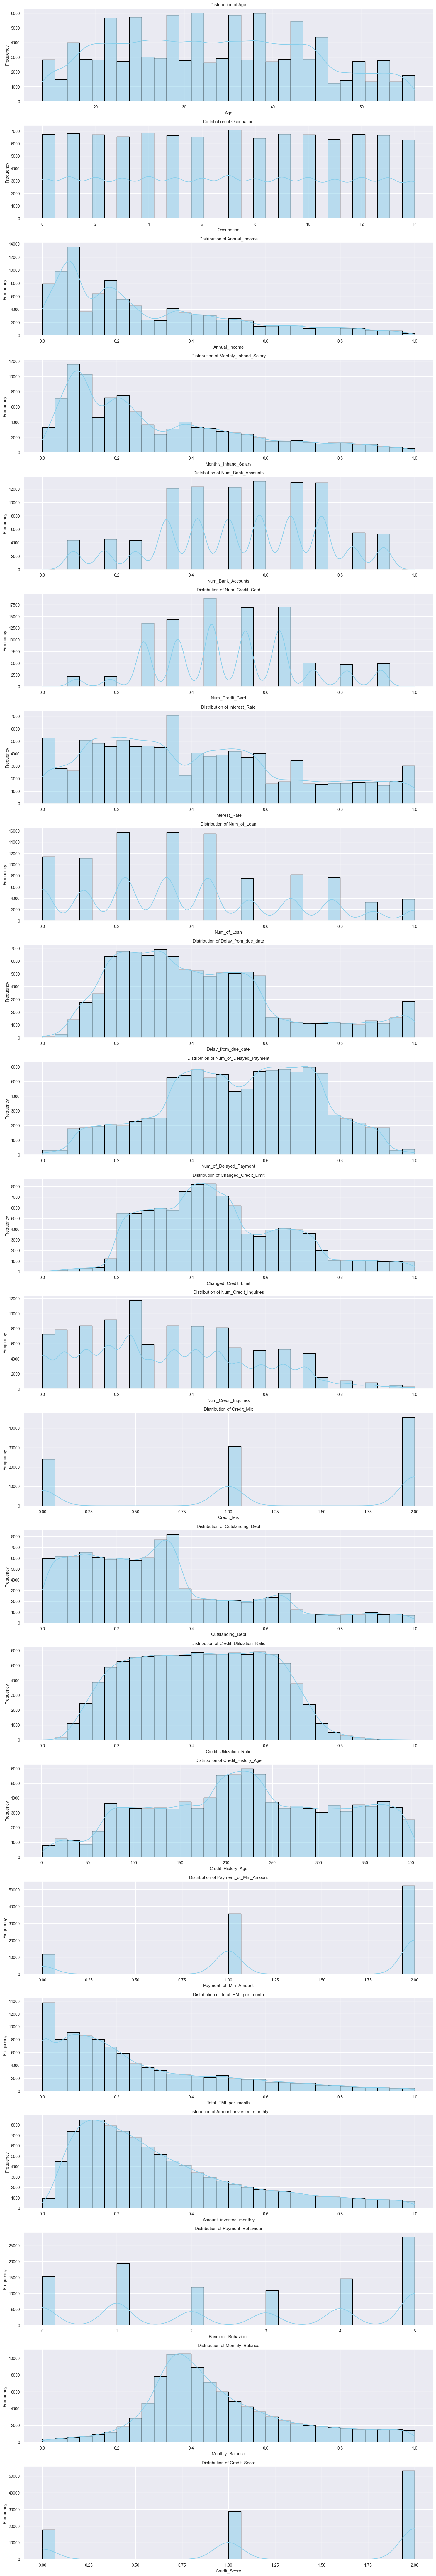

In [166]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram for each numerical attribute
plt.figure(figsize=(15, len(numeric_columns) * 4))  # Adjust height based on number of features

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.histplot(df[column], bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Pie Chart Representation of Target Variable Distribution

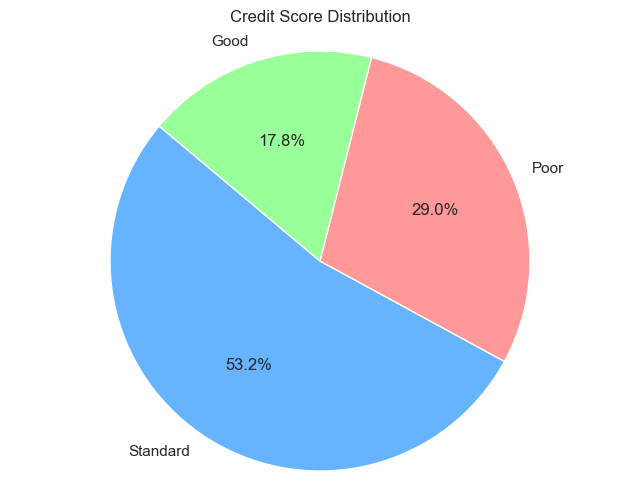

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('moodlesubmissionfilecleanedfile.csv')

label_map = {0: 'Good', 1: 'Poor', 2: 'Standard'}
df['Credit_Score_Label'] = df['Credit_Score'].map(label_map)

credit_score_counts = df['Credit_Score_Label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(credit_score_counts, labels=credit_score_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999','#99ff99'])
plt.title('Credit Score Distribution')
plt.axis('equal')
plt.show()


In [51]:
df.to_csv('FinalSubmisiONFile',index=False)

## PCA 10 file of the Preprocessed csv File

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA   

In [53]:
df=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
df=df.drop('Credit_Score',axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
pca=PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
X_scaled_df = pd.DataFrame(X_scaled,columns=df.columns)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(10)])

## Model Implementations

### Logistic Regression

#### On Original Data File


Accuracy: 64.5950%
ROC AUC Score: 79.8852
precision: 63.1999
recall: 68.5855
f1score: 63.9020


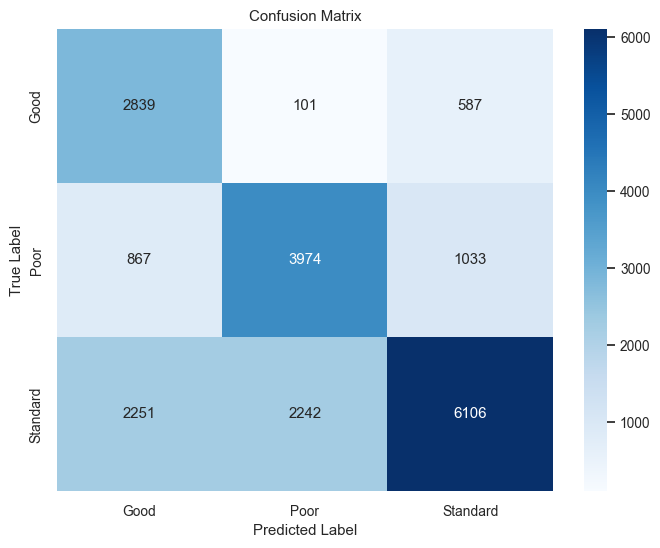

In [167]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import seaborn as sns

df = pd.read_csv('moodlesubmissionfilecleanedfile.csv')

X_reduced = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

scaler = StandardScaler()
num_cols = X_reduced.columns
X_reduced[num_cols] = scaler.fit_transform(X_reduced[num_cols])

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced')  # Remove multi_class
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [168]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.48      0.80      0.60      3527
        Poor       0.63      0.68      0.65      5874
    Standard       0.79      0.58      0.67     10599

    accuracy                           0.65     20000
   macro avg       0.63      0.69      0.64     20000
weighted avg       0.69      0.65      0.65     20000



In [169]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8642
Poor ROC AUC: 0.8024
Standard ROC AUC: 0.7300


In [170]:
cm = confusion_matrix(y_test, y_pred)

class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 80.49%
Poor Accuracy: 67.65%
Standard Accuracy: 57.61%


#### On PCA File


Accuracy: 62.0650%
ROC AUC Score: 78.0142
precision: 60.7979
recall: 65.7633
f1score: 61.3065


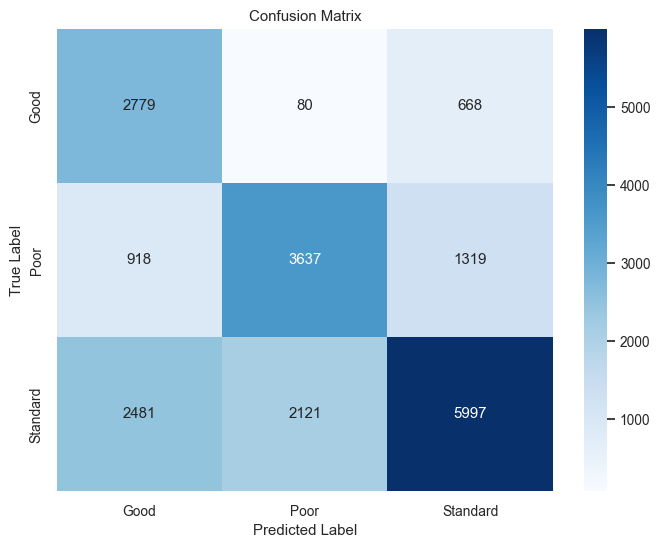

In [171]:
df = pd.read_csv('pcaupdatedcleanedfile.csv')
hg=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X= df
y =hg['Credit_Score']


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced')  # Remove multi_class
model.fit(X_train, y_train)
# Evaluate model
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [172]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.45      0.79      0.57      3527
        Poor       0.62      0.62      0.62      5874
    Standard       0.75      0.57      0.65     10599

    accuracy                           0.62     20000
   macro avg       0.61      0.66      0.61     20000
weighted avg       0.66      0.62      0.63     20000



In [173]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8469
Poor ROC AUC: 0.7893
Standard ROC AUC: 0.7042


In [174]:
cm = confusion_matrix(y_test, y_pred)

class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 78.79%
Poor Accuracy: 61.92%
Standard Accuracy: 56.58%


### K Nearest Neighbours

#### On Original File

In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv("moodlesubmissionfilecleanedfile.csv")

In [178]:
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']          

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.73665
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      3527
           1       0.74      0.73      0.73      5874
           2       0.78      0.76      0.77     10599

    accuracy                           0.74     20000
   macro avg       0.71      0.72      0.72     20000
weighted avg       0.74      0.74      0.74     20000



In [179]:

y_proba = knn.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)

C:\Users\Vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



Accuracy: 73.6650%
ROC AUC Score: 59.7731
precision: 71.4201
recall: 72.2788
f1score: 71.8174


In [180]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.63      0.68      0.65      3527
        Poor       0.74      0.73      0.73      5874
    Standard       0.78      0.76      0.77     10599

    accuracy                           0.74     20000
   macro avg       0.71      0.72      0.72     20000
weighted avg       0.74      0.74      0.74     20000



In [181]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.6846
Poor ROC AUC: 0.5872
Standard ROC AUC: 0.5214


In [182]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 67.76%
Poor Accuracy: 73.17%
Standard Accuracy: 75.90%


#### On PCA File

In [184]:
df = pd.read_csv("pcaupdatedcleanedfile.csv")
hg=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X= df
y =hg['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6615
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      3527
           1       0.66      0.63      0.64      5874
           2       0.71      0.71      0.71     10599

    accuracy                           0.66     20000
   macro avg       0.63      0.64      0.63     20000
weighted avg       0.66      0.66      0.66     20000



In [186]:

y_proba = knn.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)

C:\Users\Vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



Accuracy: 66.1500%
ROC AUC Score: 77.9685
precision: 63.1162
recall: 63.5266
f1score: 63.2619


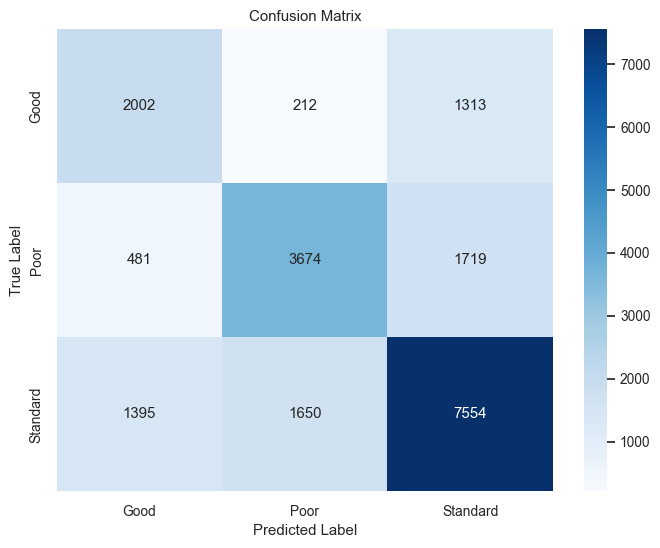

In [187]:
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [188]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.52      0.57      0.54      3527
        Poor       0.66      0.63      0.64      5874
    Standard       0.71      0.71      0.71     10599

    accuracy                           0.66     20000
   macro avg       0.63      0.64      0.63     20000
weighted avg       0.66      0.66      0.66     20000



In [189]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8277
Poor ROC AUC: 0.7931
Standard ROC AUC: 0.7182


In [190]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 56.76%
Poor Accuracy: 62.55%
Standard Accuracy: 71.27%


### Random Forest

#### On Original File


Accuracy: 81.4800%
ROC AUC Score: 92.5138
precision: 79.9601
recall: 81.8182
f1score: 80.7937


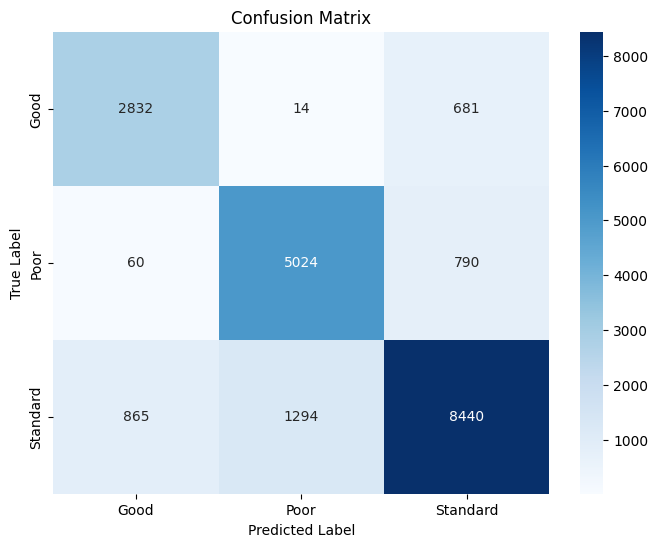

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# Load the CSV
df = pd.read_csv('moodlesubmissionfilecleanedfile.csv')

# Separate features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = clf.predict(X_test)
# Get prediction probabilities for all classes
y_proba = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [3]:
from sklearn.metrics import accuracy_score, classification_report

In [4]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.75      0.80      0.78      3527
        Poor       0.79      0.86      0.82      5874
    Standard       0.85      0.80      0.82     10599

    accuracy                           0.81     20000
   macro avg       0.80      0.82      0.81     20000
weighted avg       0.82      0.81      0.82     20000



In [5]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.9572
Poor ROC AUC: 0.9423
Standard ROC AUC: 0.8760


In [6]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 80.29%
Poor Accuracy: 85.53%
Standard Accuracy: 79.63%


#### On PCA File


Accuracy: 69.9250%
ROC AUC Score: 85.1400
precision: 67.6119
recall: 71.9234
f1score: 68.6766


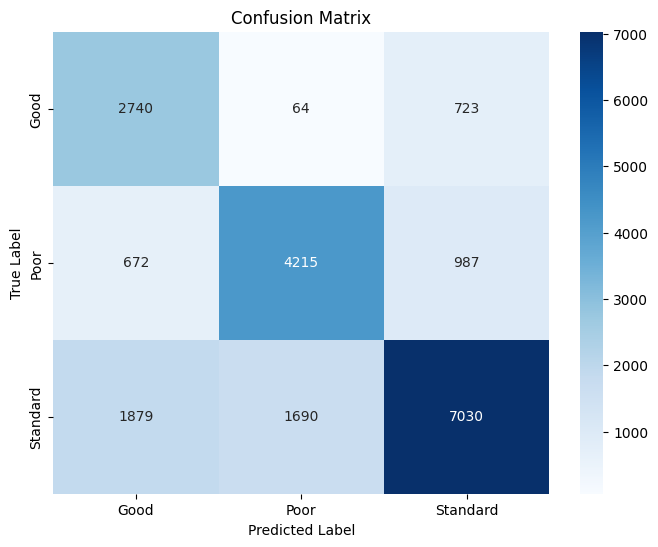

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# Load the CSV
df = pd.read_csv('pcaupdatedcleanedfile.csv')

hg=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X= df
y =hg['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = clf.predict(X_test)
# Get prediction probabilities for all classes
y_proba = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.52      0.78      0.62      3527
        Poor       0.71      0.72      0.71      5874
    Standard       0.80      0.66      0.73     10599

    accuracy                           0.70     20000
   macro avg       0.68      0.72      0.69     20000
weighted avg       0.72      0.70      0.70     20000



In [10]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8905
Poor ROC AUC: 0.8689
Standard ROC AUC: 0.7948


In [11]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 77.69%
Poor Accuracy: 71.76%
Standard Accuracy: 66.33%


### Perceptron Model

#### On Original File

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

df = pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X = df.drop(columns=['Credit_Score'])
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
clf = Perceptron(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))


0.5872
              precision    recall  f1-score   support

           0       0.55      0.00      0.00      3527
           1       0.62      0.47      0.54      5874
           2       0.58      0.85      0.69     10599

    accuracy                           0.59     20000
   macro avg       0.58      0.44      0.41     20000
weighted avg       0.58      0.59      0.52     20000



In [14]:

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)


Accuracy: 58.7200%
precision: 58.1595
recall: 43.9543
f1score: 40.8457


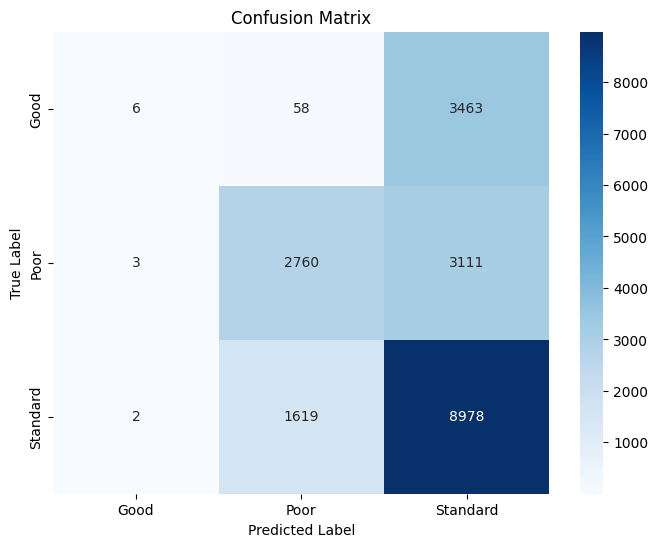

              precision    recall  f1-score   support

        Good       0.55      0.00      0.00      3527
        Poor       0.62      0.47      0.54      5874
    Standard       0.58      0.85      0.69     10599

    accuracy                           0.59     20000
   macro avg       0.58      0.44      0.41     20000
weighted avg       0.58      0.59      0.52     20000



In [17]:
class_names = ['Good', 'Poor', 'Standard']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')  # Corrected this line
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=class_names))  # Also fixed variable name


In [18]:
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.55      0.00      0.00      3527
        Poor       0.62      0.47      0.54      5874
    Standard       0.58      0.85      0.69     10599

    accuracy                           0.59     20000
   macro avg       0.58      0.44      0.41     20000
weighted avg       0.58      0.59      0.52     20000



In [19]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 0.17%
Poor Accuracy: 46.99%
Standard Accuracy: 84.71%


#### On PCA File

In [21]:
df = pd.read_csv('pcaupdatedcleanedfile.csv')

hg=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X= df
y =hg['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
clf = Perceptron(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print(accuracy)
print(classification_report(y_test, y_pred))

0.5835
              precision    recall  f1-score   support

           0       0.33      0.14      0.20      3527
           1       0.59      0.72      0.65      5874
           2       0.61      0.66      0.63     10599

    accuracy                           0.58     20000
   macro avg       0.51      0.50      0.49     20000
weighted avg       0.56      0.58      0.56     20000



In [24]:

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='macro')*100
recall = recall_score(y_test, y_pred, average='macro')*100
f1 = f1_score(y_test, y_pred, average='macro')*100
print(f"\nAccuracy: {accuracy:.4f}%")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1score: {f1:.4f}")
cm = confusion_matrix(y_test, y_pred)


Accuracy: 58.3500%
precision: 51.0618
recall: 50.4960
f1score: 49.3218


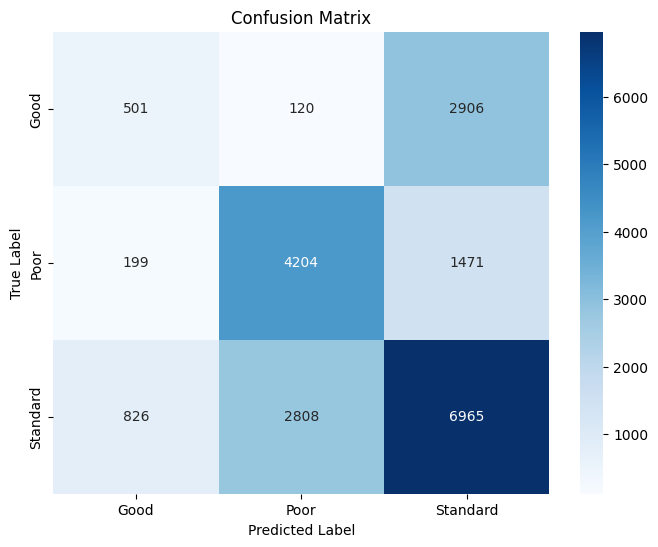

              precision    recall  f1-score   support

        Good       0.33      0.14      0.20      3527
        Poor       0.59      0.72      0.65      5874
    Standard       0.61      0.66      0.63     10599

    accuracy                           0.58     20000
   macro avg       0.51      0.50      0.49     20000
weighted avg       0.56      0.58      0.56     20000



In [25]:
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')  # <-- fixed this line
plt.show()

# Classification report
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

In [26]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 14.20%
Poor Accuracy: 71.57%
Standard Accuracy: 65.71%


### Naive Bayes Model

#### PCA File

In [29]:
#naivebayespcafrom sklearn.naive_bayes import GaussianNB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score, classification_report,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from pandas.api.types import is_string_dtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.naive_bayes import GaussianNB

import math as math
df = pd.read_csv('pcaupdatedcleanedfile.csv')

hg=pd.read_csv('moodlesubmissionfilecleanedfile.csv')
X= df
y =hg['Credit_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res= smote.fit_resample(X_train, y_train)
# Apply Naive Bayes
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

# Predict
y_pred = nb.predict(X_test)
# Evaluate
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"\nAccuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}%")
print(f"Recall: {recall:.4f}%")
print(f"F1-score: {f1:.4f}%")

# (Optional) Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 61.5800%
Precision: 66.0423%
Recall: 61.5800%
F1-score: 62.0716%

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.80      0.57      3527
           1       0.63      0.61      0.62      5874
           2       0.75      0.55      0.64     10599

    accuracy                           0.62     20000
   macro avg       0.61      0.66      0.61     20000
weighted avg       0.66      0.62      0.62     20000



In [30]:
from sklearn.metrics import roc_auc_score

model = GaussianNB()
model.fit(X_train, y_train)

# Get predicted probabilities
y_proba = model.predict_proba(X_test)

# ROC AUC (for multiclass)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.7785


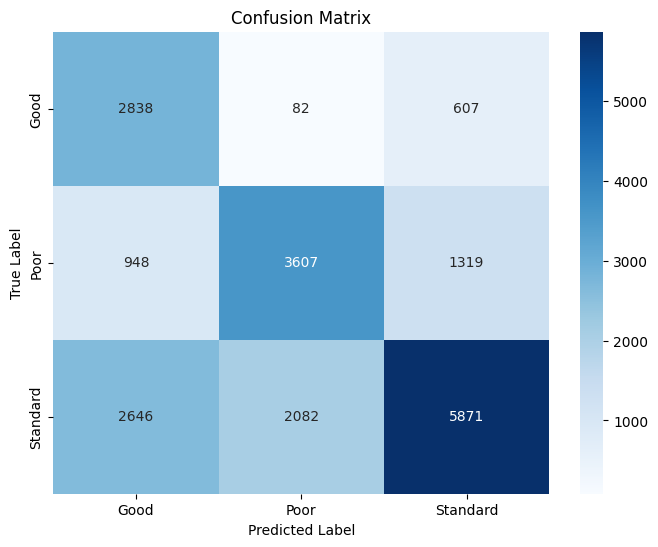

In [31]:
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, classification_report
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.44      0.80      0.57      3527
        Poor       0.63      0.61      0.62      5874
    Standard       0.75      0.55      0.64     10599

    accuracy                           0.62     20000
   macro avg       0.61      0.66      0.61     20000
weighted avg       0.66      0.62      0.62     20000



In [33]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8437
Poor ROC AUC: 0.7839
Standard ROC AUC: 0.7079


In [34]:
cm = confusion_matrix(y_test, y_pred)

# Class-wise accuracy = correct predictions / total true samples per class
class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 80.46%
Poor Accuracy: 61.41%
Standard Accuracy: 55.39%


#### Original File

In [36]:
df=pd.read_csv('moodlesubmissionfilecleanedfile.csv')

In [37]:
X=df.drop(['Credit_Score'],axis=1)
y=df['Credit_Score']

In [38]:
from imblearn.over_sampling import SMOTE
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res= smote.fit_resample(X_train, y_train)
# Apply Naive Bayes
nb = GaussianNB()
nb.fit(X_train_res, y_train_res)

# Predict
y_pred = nb.predict(X_test)
# Evaluate
accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred, average='weighted') * 100
recall = recall_score(y_test, y_pred, average='weighted') * 100
f1 = f1_score(y_test, y_pred, average='weighted') * 100

print(f"\nAccuracy: {accuracy:.4f}%")
print(f"Precision: {precision:.4f}%")
print(f"Recall: {recall:.4f}%")
print(f"F1-score: {f1:.4f}%")

# (Optional) Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 62.6600%
Precision: 69.6971%
Recall: 62.6600%
F1-score: 62.9239%

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.83      0.58      3527
           1       0.62      0.73      0.67      5874
           2       0.83      0.50      0.62     10599

    accuracy                           0.63     20000
   macro avg       0.63      0.69      0.62     20000
weighted avg       0.70      0.63      0.63     20000



In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the y_test labels (for multiclass ROC-AUC)
classes = nb.classes_  # or np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities for all classes
y_probs = nb.predict_proba(X_test)

# Compute multi-class ROC-AUC using One-vs-Rest (OvR)
auc = roc_auc_score(y_test_bin, y_probs, average='macro', multi_class='ovr')*100
print("Multiclass ROC-AUC Score:", auc)


Multiclass ROC-AUC Score: 77.3202220866391


In [40]:
from sklearn.metrics import roc_auc_score

model = GaussianNB()
model.fit(X_train, y_train)

# Get predicted probabilities
y_proba = model.predict_proba(X_test)

# ROC AUC (for multiclass)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.7721


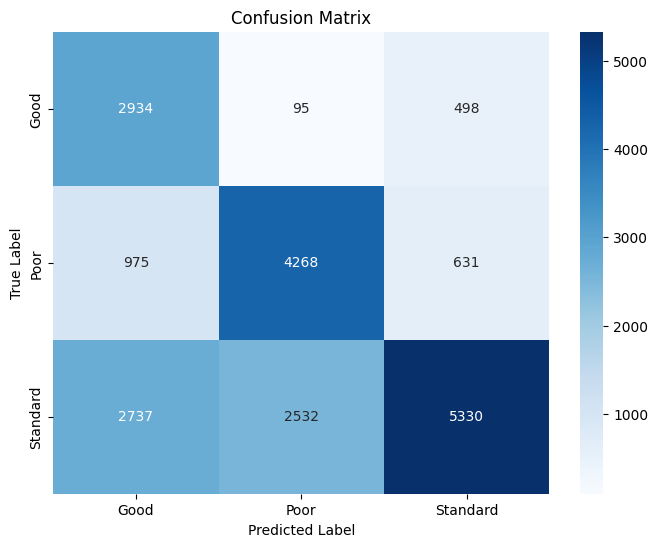

In [41]:
cm = confusion_matrix(y_test, y_pred)

# Class names
class_names = ['Good', 'Poor', 'Standard']

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, classification_report
target = ['Good', 'Poor', 'Standard']
print(classification_report(y_test, y_pred, target_names=target))

              precision    recall  f1-score   support

        Good       0.44      0.83      0.58      3527
        Poor       0.62      0.73      0.67      5874
    Standard       0.83      0.50      0.62     10599

    accuracy                           0.63     20000
   macro avg       0.63      0.69      0.62     20000
weighted avg       0.70      0.63      0.63     20000



In [43]:
class_wise_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average=None)

# Display class-wise AUC
class_names = ['Good', 'Poor', 'Standard']
for name, score in zip(class_names, class_wise_auc):
    print(f"{name} ROC AUC: {score:.4f}")

Good ROC AUC: 0.8496
Poor ROC AUC: 0.7641
Standard ROC AUC: 0.7026


In [44]:

cm = confusion_matrix(y_test, y_pred)

class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

# Display
class_names = ['Good', 'Poor', 'Standard']
for name, acc in zip(class_names, class_wise_accuracy):
    print(f"{name} Accuracy: {acc * 100:.2f}%")

Good Accuracy: 83.19%
Poor Accuracy: 72.66%
Standard Accuracy: 50.29%


### Neural Network

#### Original File

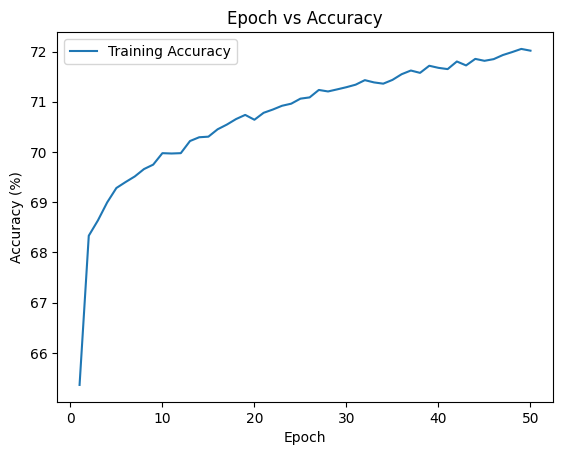

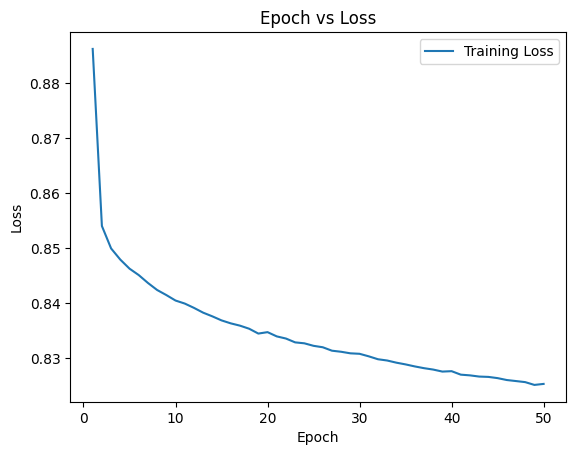

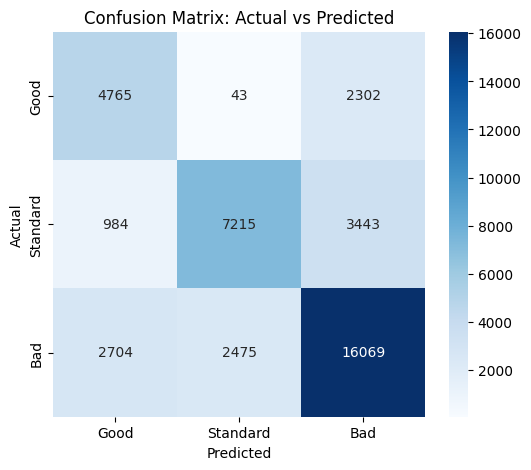


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      67.02     0.56      0.67      0.61      0.88      
Standard  61.97     0.74      0.62      0.68      0.81      
Bad       75.63     0.74      0.76      0.75      0.79      

Macro-Averaged ROC AUC Score (OvR): 0.8244
Overall Test Accuracy: 70.12%

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       68.2060
Precision      0.6805
Recall         0.6821
F1-Score       0.6779
ROC AUC        0.8244


/var/folders/yr/_4jwhtzj3n17n2hj7fsgm6vm0000gn/T/ipykernel_96679/1057974151.py:134: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  y_scores_tensor = torch.tensor(y_scores)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("moodlesubmissionfilecleanedfile.csv") 

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class CreditScoreNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CreditScoreNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

def Model_Train(epoch):
    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = 3

    model = CreditScoreNN(input_size, hidden_size, output_size)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    num_epochs = epoch
    train_accuracies = []
    train_losses = []

    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = (correct / total) * 100
        train_accuracies.append(train_accuracy)
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

    
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Epoch vs Accuracy')
    plt.legend()
    plt.show()

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.show()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        y_scores = []

        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
            y_scores.extend(outputs.numpy())

        confusion = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Good', 'Standard', 'Bad'],
                    yticklabels=['Good', 'Standard', 'Bad'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix: Actual vs Predicted')
        plt.show()

        class_labels = ['Good', 'Standard', 'Bad']
        class_counts = confusion.sum(axis=1)
        class_correct = confusion.diagonal()
        class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)

        y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
        y_scores_tensor = torch.tensor(y_scores)
        aucs = []
        for i in range(3):
            auc = roc_auc_score(y_true_bin[:, i], y_scores_tensor[:, i])
            aucs.append(auc)

        print("\nPer-Class Metrics Table:")
        print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
        print("-" * 68)
        for i in range(3):
            print(f"{class_labels[i]:<10}{class_accuracy[i]:<10.2f}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{aucs[i]:<10.2f}")

        macro_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
        print(f"\nMacro-Averaged ROC AUC Score (OvR): {macro_auc:.4f}")

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )

        macro_accuracy = sum(class_accuracy) / len(class_accuracy)

        test_accuracy = (correct / total) * 100
        print(f"Overall Test Accuracy: {test_accuracy:.2f}%")
        print("\nMacro-Averaged Metrics:")
        print(f"{'Metric':<15}{'Score'}")
        print("-" * 30)
        print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
        print(f"{'Precision':<15}{precision_macro:.4f}")
        print(f"{'Recall':<15}{recall_macro:.4f}")
        print(f"{'F1-Score':<15}{f1_macro:.4f}")
        print(f"{'ROC AUC':<15}{macro_auc:.4f}")

Model_Train(epoch=50)

#### PCA File

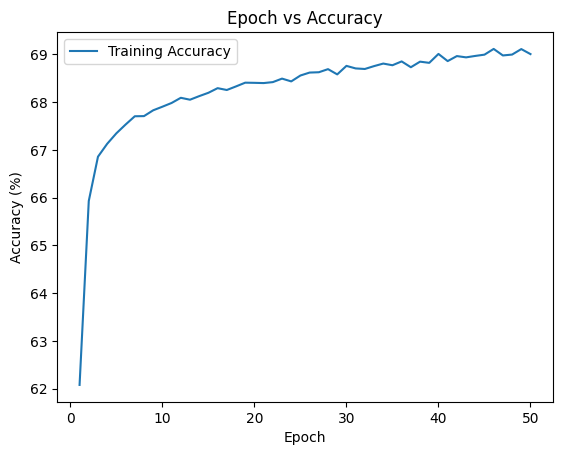

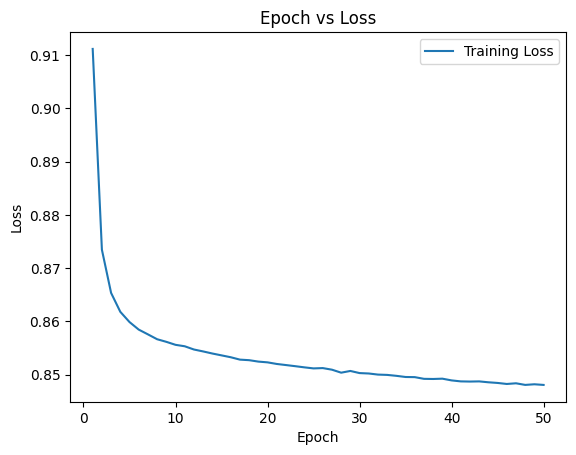

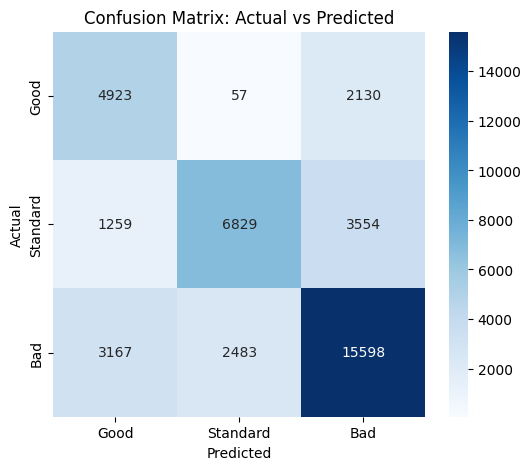


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      69.24     0.53      0.69      0.60      0.85      
Standard  58.66     0.73      0.59      0.65      0.82      
Bad       73.41     0.73      0.73      0.73      0.78      

Macro-Averaged ROC AUC Score (OvR): 0.8140
Overall Test Accuracy: 68.38%

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       67.1027
Precision      0.6628
Recall         0.6710
F1-Score       0.6606
ROC AUC        0.8140


In [2]:
df = pd.read_csv("pca_transformed_dataset.csv") 

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long) 
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class CreditScoreNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CreditScoreNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

def Model_Train(epoch):
    input_size = X_train.shape[1]
    hidden_size = 64
    output_size = 3

    model = CreditScoreNN(input_size, hidden_size, output_size)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

    test_data = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

    num_epochs = epoch
    train_accuracies = []
    train_losses = []

    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = (correct / total) * 100
        train_accuracies.append(train_accuracy)
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

    
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Epoch vs Accuracy')
    plt.legend()
    plt.show()

    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.show()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        y_scores = []

        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
            y_scores.extend(outputs.numpy())

        confusion = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Good', 'Standard', 'Bad'],
                    yticklabels=['Good', 'Standard', 'Bad'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix: Actual vs Predicted')
        plt.show()

        class_labels = ['Good', 'Standard', 'Bad']
        class_counts = confusion.sum(axis=1)
        class_correct = confusion.diagonal()
        class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)

        y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
        y_scores_tensor = torch.tensor(y_scores)
        aucs = []
        for i in range(3):
            auc = roc_auc_score(y_true_bin[:, i], y_scores_tensor[:, i])
            aucs.append(auc)

        print("\nPer-Class Metrics Table:")
        print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
        print("-" * 68)
        for i in range(3):
            print(f"{class_labels[i]:<10}{class_accuracy[i]:<10.2f}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1[i]:<10.2f}{aucs[i]:<10.2f}")

        macro_auc = roc_auc_score(y_true_bin, y_scores, average='macro', multi_class='ovr')
        print(f"\nMacro-Averaged ROC AUC Score (OvR): {macro_auc:.4f}")

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0
        )

        macro_accuracy = sum(class_accuracy) / len(class_accuracy)

        test_accuracy = (correct / total) * 100
        print(f"Overall Test Accuracy: {test_accuracy:.2f}%")
        print("\nMacro-Averaged Metrics:")
        print(f"{'Metric':<15}{'Score'}")
        print("-" * 30)
        print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
        print(f"{'Precision':<15}{precision_macro:.4f}")
        print(f"{'Recall':<15}{recall_macro:.4f}")
        print(f"{'F1-Score':<15}{f1_macro:.4f}")
        print(f"{'ROC AUC':<15}{macro_auc:.4f}")

Model_Train(epoch=50)

### Decision Trees

#### Original File

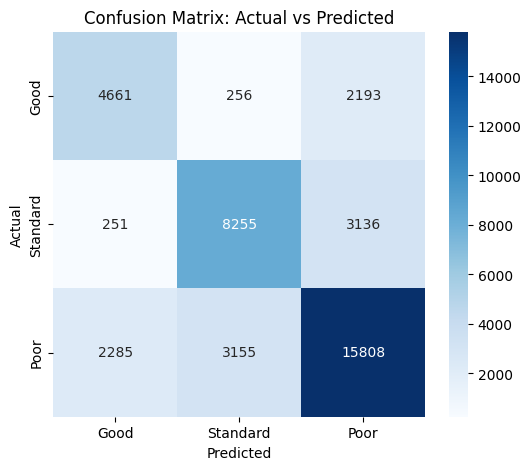


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      65.56       0.65        0.66        0.65        0.79      
Standard  70.91       0.71        0.71        0.71        0.79      
Poor      74.40       0.75        0.74        0.75        0.73      

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       70.2867
Precision      0.7010
Recall         0.7029
F1-Score       0.7019
ROC AUC        0.7712

Overall Test Accuracy: 71.81%


In [4]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_recall_fscore_support, 
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("moodlesubmissionfilecleanedfile.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['Good', 'Standard', 'Poor']

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Actual vs Predicted')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)
class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table:")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<12.2f}{precision[i]:<12.2f}{recall[i]:<12.2f}{f1[i]:<12.2f}{aucs[i]:<10.2f}")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = np.mean(class_accuracy)
macro_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
overall_accuracy = np.sum(class_correct) / np.sum(conf_matrix) * 100

print("\nMacro-Averaged Metrics:")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

#### PCA File

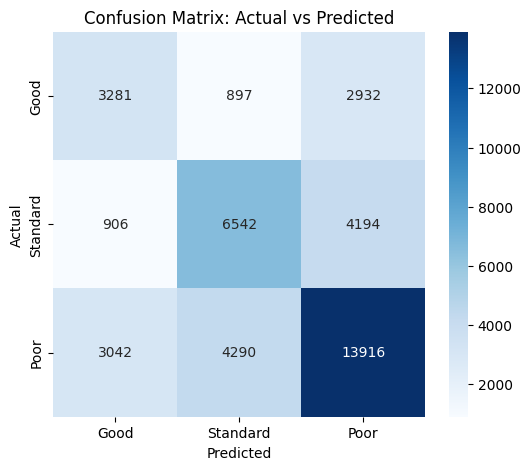


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      46.15       0.45        0.46        0.46        0.67      
Standard  56.19       0.56        0.56        0.56        0.69      
Poor      65.49       0.66        0.65        0.66        0.64      

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       55.9442
Precision      0.5577
Recall         0.5594
F1-Score       0.5585
ROC AUC        0.6659

Overall Test Accuracy: 59.35%


In [5]:
df = pd.read_csv("pca_transformed_dataset.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = ['Good', 'Standard', 'Poor']

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Actual vs Predicted')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)
class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table:")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<12.2f}{precision[i]:<12.2f}{recall[i]:<12.2f}{f1[i]:<12.2f}{aucs[i]:<10.2f}")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = np.mean(class_accuracy)
macro_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
overall_accuracy = np.sum(class_correct) / np.sum(conf_matrix) * 100

print("\nMacro-Averaged Metrics:")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

### Gradient Boosting

#### Original File

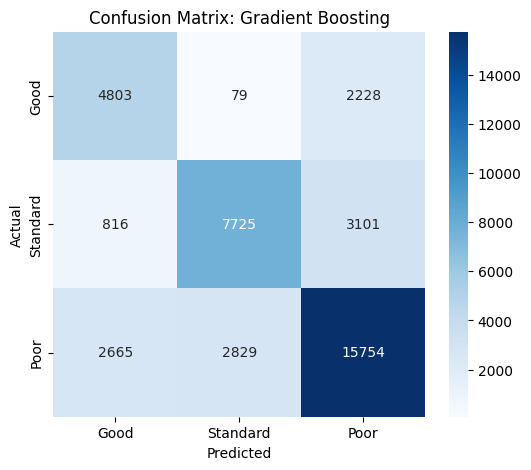


Per-Class Metrics Table (Gradient Boosting):
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      67.55       0.58        0.68        0.62        0.89      
Standard  66.35       0.73        0.66        0.69        0.87      
Poor      74.14       0.75        0.74        0.74        0.80      

Macro-Averaged Metrics (Gradient Boosting):
Metric         Score
------------------------------
Accuracy       69.3503
Precision      0.6845
Recall         0.6935
F1-Score       0.6873
ROC AUC        0.8512

Overall Test Accuracy: 70.70%


In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_recall_fscore_support, 
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("moodlesubmissionfilecleanedfile.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

class_labels = ['Good', 'Standard', 'Poor']

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Gradient Boosting')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)
class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table (Gradient Boosting):")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<12.2f}{precision[i]:<12.2f}{recall[i]:<12.2f}{f1[i]:<12.2f}{aucs[i]:<10.2f}")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = np.mean(class_accuracy)
macro_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
overall_accuracy = np.sum(class_correct) / np.sum(conf_matrix) * 100

print("\nMacro-Averaged Metrics (Gradient Boosting):")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

#### PCA File

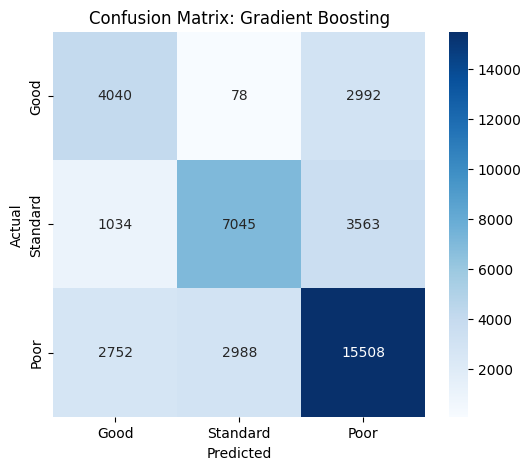


Per-Class Metrics Table (Gradient Boosting):
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      56.82       0.52        0.57        0.54        0.86      
Standard  60.51       0.70        0.61        0.65        0.84      
Poor      72.99       0.70        0.73        0.72        0.77      

Macro-Averaged Metrics (Gradient Boosting):
Metric         Score
------------------------------
Accuracy       63.4402
Precision      0.6386
Recall         0.6344
F1-Score       0.6349
ROC AUC        0.8218

Overall Test Accuracy: 66.48%


In [7]:
df = pd.read_csv("pca_transformed_dataset.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

class_labels = ['Good', 'Standard', 'Poor']

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Gradient Boosting')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)
class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table (Gradient Boosting):")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<12.2f}{precision[i]:<12.2f}{recall[i]:<12.2f}{f1[i]:<12.2f}{aucs[i]:<10.2f}")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = np.mean(class_accuracy)
macro_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
overall_accuracy = np.sum(class_correct) / np.sum(conf_matrix) * 100

print("\nMacro-Averaged Metrics (Gradient Boosting):")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")

### CatBoosting

#### Original File

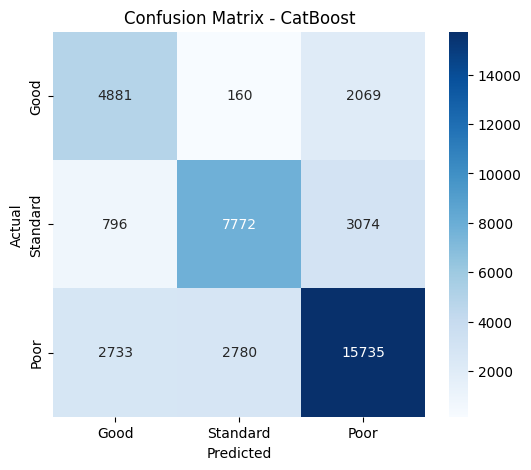


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      68.65     0.5804      0.6865      0.6290      0.8926    
Standard  66.76     0.7255      0.6676      0.6954      0.8676    
Poor      74.05     0.7537      0.7405      0.7470      0.8007    

Overall Test Accuracy: 70.97%

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       69.8207
Precision      0.6865
Recall         0.6982
F1-Score       0.6905
ROC AUC        0.8536


In [8]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np

df = pd.read_csv("moodlesubmissionfilecleanedfile.csv")

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

class_labels = ['Good', 'Standard', 'Poor']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=0
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

y_proba = model.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()

class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)

y_true_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table:")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<10.2f}{precision[i]:<12.4f}{recall[i]:<12.4f}{f1[i]:<12.4f}{aucs[i]:<10.4f}")

macro_auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = sum(class_accuracy) / len(class_accuracy)

overall_accuracy = (y_pred == y_test).mean() * 100

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")
print("\nMacro-Averaged Metrics:")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

#### PCA File

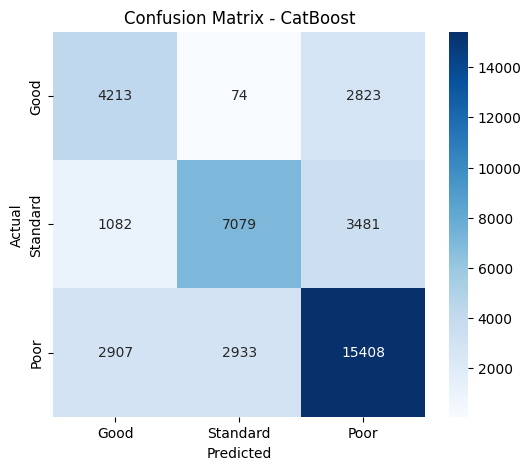


Per-Class Metrics Table:
Class     Accuracy    Precision   Recall      F1-Score    ROC AUC   
--------------------------------------------------------------------
Good      59.25     0.5137      0.5925      0.5503      0.8663    
Standard  60.81     0.7019      0.6081      0.6516      0.8410    
Poor      72.52     0.7097      0.7252      0.7173      0.7698    

Overall Test Accuracy: 66.75%

Macro-Averaged Metrics:
Metric         Score
------------------------------
Accuracy       64.1918
Precision      0.6417
Recall         0.6419
F1-Score       0.6397
ROC AUC        0.8257


In [9]:
df = pd.read_csv("pca_transformed_dataset.csv") 

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

class_labels = ['Good', 'Standard', 'Poor']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=0
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = y_pred.flatten()

y_proba = model.predict_proba(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CatBoost')
plt.show()

class_counts = conf_matrix.sum(axis=1)
class_correct = conf_matrix.diagonal()
class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[0, 1, 2], zero_division=0)

y_true_bin = label_binarize(y_test, classes=[0, 1, 2])
aucs = []
for i in range(3):
    auc = roc_auc_score(y_true_bin[:, i], y_proba[:, i])
    aucs.append(auc)

print("\nPer-Class Metrics Table:")
print(f"{'Class':<10}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC AUC':<10}")
print("-" * 68)
for i in range(3):
    print(f"{class_labels[i]:<10}{class_accuracy[i]:<10.2f}{precision[i]:<12.4f}{recall[i]:<12.4f}{f1[i]:<12.4f}{aucs[i]:<10.4f}")

macro_auc = roc_auc_score(y_true_bin, y_proba, average='macro', multi_class='ovr')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
macro_accuracy = sum(class_accuracy) / len(class_accuracy)

overall_accuracy = (y_pred == y_test).mean() * 100

print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")
print("\nMacro-Averaged Metrics:")
print(f"{'Metric':<15}{'Score'}")
print("-" * 30)
print(f"{'Accuracy':<15}{macro_accuracy:.4f}")
print(f"{'Precision':<15}{precision_macro:.4f}")
print(f"{'Recall':<15}{recall_macro:.4f}")
print(f"{'F1-Score':<15}{f1_macro:.4f}")
print(f"{'ROC AUC':<15}{macro_auc:.4f}")

### SVM Model

The dataset having almost 100,000 records, the SVM model takes almost 20 minutes to run to completion. For this reason, the SVM code is commented below. It may be uncommented and ran

In [10]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
# from sklearn.svm import SVC
# from sklearn.metrics import (
#     classification_report,
#     accuracy_score,
#     precision_score,
#     recall_score,
#     f1_score,
#     roc_auc_score,
#     confusion_matrix,
#     precision_recall_fscore_support
# )

# from imblearn.over_sampling import SMOTE
# from tabulate import tabulate 

# df = pd.read_csv('moodlesubmissionfilecleanedfile.csv')

# X = df.drop(columns=['Credit_Score'])
# y = df['Credit_Score']

# if y.dtype == 'object':
#     le = LabelEncoder()
#     y = le.fit_transform(y)
#     class_labels = le.classes_
# else:
#     class_labels = ['Good', 'Standard', 'Bad']

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# smote = SMOTE(random_state=42)
# X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# svm_model = SVC(kernel='linear', C=1.0, probability=True)
# svm_model.fit(X_train_sm, y_train_sm)

# y_pred = svm_model.predict(X_test)
# y_prob = svm_model.predict_proba(X_test)

# confusion = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 5))
# sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix: Actual vs Predicted')
# plt.show()

# class_counts = confusion.sum(axis=1)
# class_correct = confusion.diagonal()
# class_accuracy = [(class_correct[i] / class_counts[i]) * 100 if class_counts[i] > 0 else 0 for i in range(len(class_labels))]

# precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0)

# y_test_bin = label_binarize(y_test, classes=np.unique(y))
# roc_aucs = [roc_auc_score(y_test_bin[:, i], y_prob[:, i]) for i in range(len(class_labels))]

# rows = []
# for i in range(len(class_labels)):
#     rows.append([
#         class_labels[i],
#         f"{class_accuracy[i]:.2f}",
#         f"{precision[i]:.2f}",
#         f"{recall[i]:.2f}",
#         f"{f1[i]:.2f}",
#         f"{roc_aucs[i]:.2f}"
#     ])

# headers = ['Class', 'Accuracy (%)', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
# print("\nPer-Class Metrics Table:")
# print(tabulate(rows, headers=headers, tablefmt='pretty'))

# overall_accuracy = accuracy_score(y_test, y_pred)
# macro_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
# macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
# macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
# macro_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')

# print("\nOverall Metrics:")
# print(f"Overall Accuracy:  {overall_accuracy:.2f}")
# print(f"Macro Precision:   {macro_precision:.2f}")
# print(f"Macro Recall:      {macro_recall:.2f}")
# print(f"Macro F1-score:    {macro_f1:.2f}")
# print(f"Macro ROC AUC:     {macro_auc:.4f}")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Comparison of Graphs

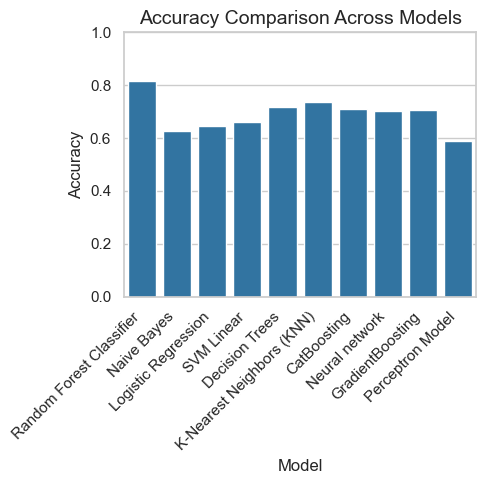

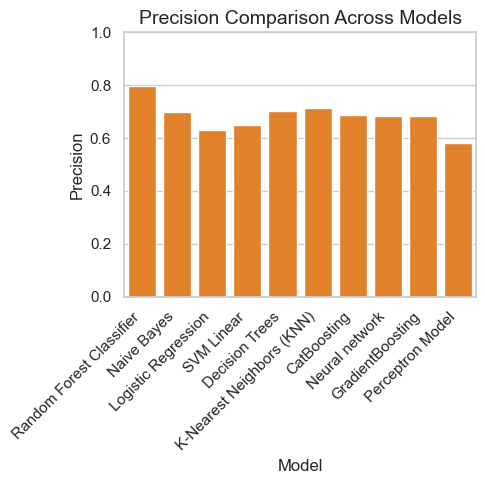

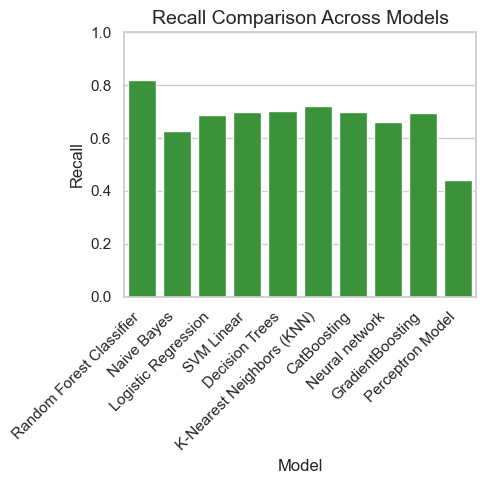

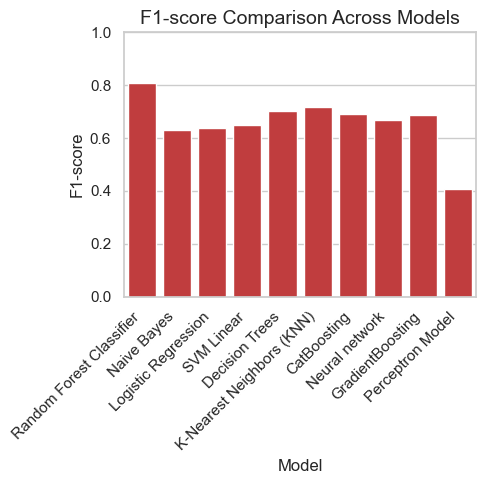

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
data = {
    'Model': [
        'Random Forest Classifier', 'Naive Bayes', 'Logistic Regression', 'SVM Linear', 'Decision Trees', 'K-Nearest Neighbors (KNN)',
        'CatBoosting', 'Neural network','GradientBoosting','Perceptron Model',
    ],
    'Accuracy': [0.8148, 0.6266, 0.6459, 0.66, 0.7181, 0.736650, 0.7097, 0.7006, 0.7070, 0.5872],
    'Precision': [0.79601, 0.6969, 0.63199, 0.65, 0.7010, 0.7142, 0.6865, 0.6829, 0.6845, 0.581595],
    'Recall': [0.8181, 0.6266, 0.685855, 0.70, 0.7029, 0.7227, 0.6982, 0.6589, 0.6935, 0.439543],
    'F1-score': [0.8079, 0.6292, 0.639020, 0.65, 0.7019, 0.718, 0.6905, 0.6689, 0.6873, 0.408457]
}



df = pd.DataFrame(data)

# Set seaborn style
sns.set(style="whitegrid")

# Define unique colors for each metric plot
colors = {
    'Accuracy': '#1f77b4',    # blue
    'Precision': '#ff7f0e',   # orange
    'Recall': '#2ca02c',      # green
    'F1-score': '#d62728'     # red
}

# Generate one plot per metric with individual color
for metric, color in colors.items():
    plt.figure(figsize=(5, 5))
    sns.barplot(data=df, x='Model', y=metric, color=color)
    plt.title(f'{metric} Comparison Across Models', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()

   # plt.savefig(f'{metric}_comparison.png', dpi=300)  # Save with high resolution
    #plt.close()

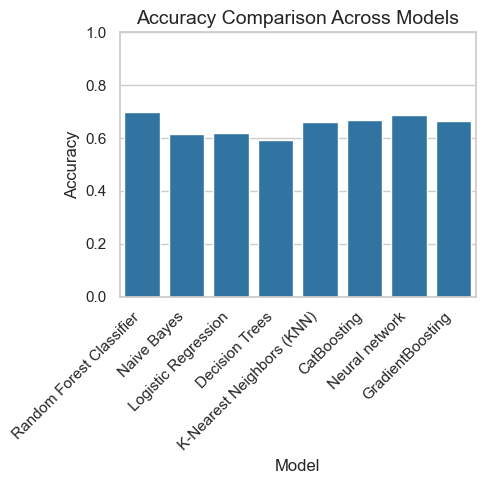

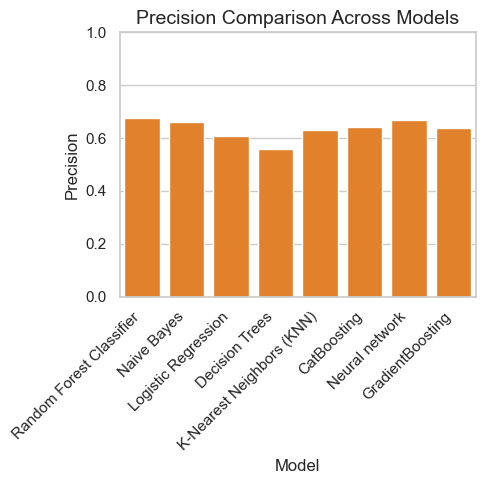

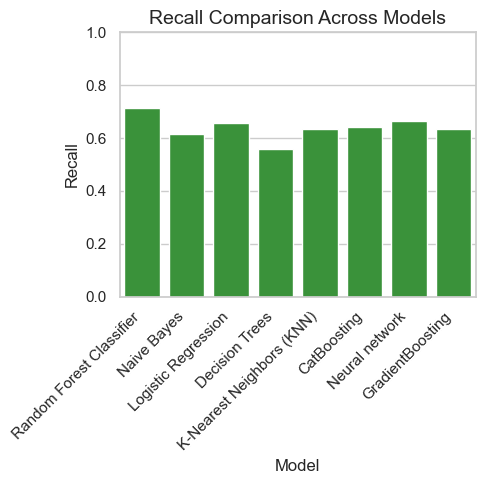

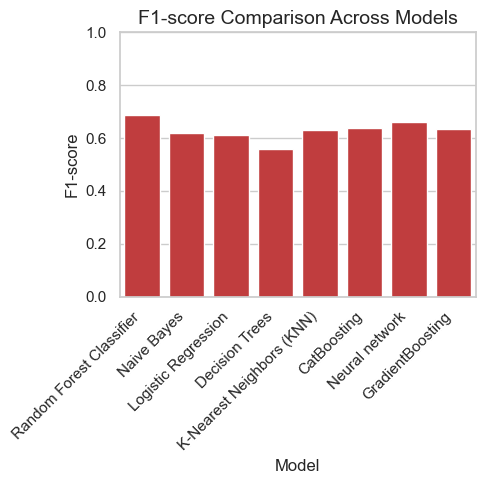

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
data = {
    'Model': [
        'Random Forest Classifier', 'Naive Bayes', 'Logistic Regression', 'Decision Trees', 'K-Nearest Neighbors (KNN)',
        'CatBoosting', 'Neural network','GradientBoosting',
    ],
    'Accuracy': [0.699250, 0.6158, 0.6206, 0.5935, 0.6615, 0.66675, 0.6873, 0.6648],
    'Precision': [0.67619, 0.6604, 0.6079, 0.5577, 0.631162, 0.6417, 0.66765, 0.6386],
    'Recall': [0.712, 0.6158, 0.657633, 0.5594, 0.635266, 0.6419, 0.6650, 0.6344],
    'F1-score': [0.6867, 0.620716, 0.613065, 0.5585, 0.631619, 0.6397, 0.6614, 0.6349]
}



df = pd.DataFrame(data)

# Set seaborn style
sns.set(style="whitegrid")

# Define unique colors for each metric plot
colors = {
    'Accuracy': '#1f77b4',    # blue
    'Precision': '#ff7f0e',   # orange
    'Recall': '#2ca02c',      # green
    'F1-score': '#d62728'     # red
}

# Generate one plot per metric with individual color
for metric, color in colors.items():
    plt.figure(figsize=(5, 5))
    sns.barplot(data=df, x='Model', y=metric, color=color)
    plt.title(f'{metric} Comparison Across Models', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()

   # plt.savefig(f'{metric}_comparison.png', dpi=300)  # Save with high resolution
    #plt.close()